In [2]:
# Get the data for expeirment
import sklearn
import pandas as pd 
import numpy as np
import time

from sklearn import tree
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.metrics import explained_variance_score, mean_squared_error
from scipy.spatial.distance import cdist
from numpy.linalg import pinv
from math import sqrt

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import geopy.distance as distance
from sklearn.preprocessing import MinMaxScaler

import Data_utils
import matplotlib.ticker as ticker
from functools import reduce
from collections import Counter

In [3]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# Experiment results for all 6 features (precip is removed)

In [4]:
# training = pd.read_csv('Data/ab_wind_train_data.txt')
# testing = pd.read_csv('Data/ab_wind_test_data.txt')
# All data without null, 2.5m
data = pd.read_csv('Data/processed_ab_wind_no_precip.csv')
#data = pd.read_csv('Data/processed_ab_wind.csv')

C:\Users\PPL\AppData\Local\Temp\ipykernel_154288\4035513363.py:4: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('Data/processed_ab_wind_no_precip.csv')


In [5]:
data

longitude  latitude         name       id              date  temp  \
0          -112.82     53.05      CAMROSE  3011240  2010-01-01 00:00 -29.7   
1          -112.82     53.05      CAMROSE  3011240  2010-01-01 01:00 -28.7   
2          -112.82     53.05      CAMROSE  3011240  2010-01-01 02:00 -29.6   
3          -112.82     53.05      CAMROSE  3011240  2010-01-01 03:00 -28.9   
4          -112.82     53.05      CAMROSE  3011240  2010-01-01 04:00 -28.9   
...            ...       ...          ...      ...               ...   ...   
4899354    -110.28     54.42  COLD LAKE A  3081680  2023-09-14 19:00  12.6   
4899355    -110.28     54.42  COLD LAKE A  3081680  2023-09-14 20:00   9.9   
4899356    -110.28     54.42  COLD LAKE A  3081680  2023-09-14 21:00   9.7   
4899357    -110.28     54.42  COLD LAKE A  3081680  2023-09-14 22:00   8.8   
4899358    -110.28     54.42  COLD LAKE A  3081680  2023-09-14 23:00   6.9   

         wind_direction  wind_speed  
0                  13.0        13.0  
1                  14.0        19.0  
2                  14.0        15.0  
3                  14.0        20.0  
4                  14.0        20.0  
...                 ...         ...  
4899354            26.0         8.0  
4899355            23.0         5.0  
4899356            25.0         9.0  
4899357            24.0         5.0  
4899358            21.0         8.0  

[4899359 rows x 8 columns]

In [15]:
train_data = pd.read_csv('Data\processed_ab_no_precp_train.txt').sample(frac=0.5)
test_data = pd.read_csv('Data\processed_ab_no_precp_test.txt')

C:\Users\PPL\AppData\Local\Temp\ipykernel_9064\3290916170.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv('Data\processed_ab_no_precp_train.txt').sample(frac=0.5)
C:\Users\PPL\AppData\Local\Temp\ipykernel_9064\3290916170.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  test_data = pd.read_csv('Data\processed_ab_no_precp_test.txt')


In [5]:
train_data.loc[:,['wind_speed', 'wind_direction']]

wind_speed  wind_direction
0             11.0            23.0
1              6.0            28.0
2              6.0             6.0
3             19.0            27.0
4             19.0            28.0
...            ...             ...
534295         4.0            21.0
534296         1.0             3.0
534297         7.0            24.0
534298         3.0            23.0
534299         2.0            15.0

[534300 rows x 2 columns]

In [6]:
# Source: From the TSmodel
def preprocess_data(train, validation):
    scaler = StandardScaler()
    train_data = scaler.fit_transform(train)
    validation_data = scaler.transform(validation)
    
    return train_data, validation_data

In [7]:
def multiple_target_fcm_rule_model(train_x, train_y, validation_x, validation_y):
    train_y_1 = train_y[:,0]
    train_y_2 = train_y[:,1]
    validation_y_1 = validation_y[:,0]
    validation_y_2 = validation_y[:,1]
    
    rmse_train_1, rmse_validation_1, time_used_1 = fcm_rule_model(train_x, train_y_1, validation_x, validation_y_1)
    rmse_train_2, rmse_validation_2, time_used_2 = fcm_rule_model(train_x, train_y_2, validation_x, validation_y_2)
    
    return rmse_train_1, rmse_train_2, rmse_validation_1, rmse_validation_2, time_used_1 + time_used_2

In [8]:
def fcm_rule_model(train_x, train_y, validation_x, validation_y):
    start_time = time.time()

    # Fcm hyperparameters
    FCM_Nc = 30
    FCM_m = 2
    #tol = 1e-10
    max_iter = 200
        
    N = train_x.shape[0]
    U = np.random.rand(N, FCM_Nc)
    U = U / np.sum(U, axis=1, keepdims=True)
    qs = []

    # Fuzzy C-Means 聚类
    for _ in range(max_iter):
        U_old = U.copy()
        mf = U ** FCM_m
        cen = np.dot(mf.T, train_x) / np.sum(mf, axis=0, keepdims=True).T
        dists = cdist(train_x, cen)
        tmp = np.power(dists, -2 / (FCM_m - 1))
        U = tmp / np.sum(tmp, axis=1, keepdims=True)

        q = np.sum((U ** FCM_m) * (dists ** 2))
        qs.append(q)

        # 检查是否收敛
#         if np.linalg.norm(U - U_old) < tol:
#             break
    # 模型训练 find if this can be optimized
    z = np.hstack((np.ones((N, 1)), train_x))
    H = np.zeros((N, FCM_Nc * (train_x.shape[1] + 1)))

    # 生成模糊规则矩阵 H
    for j in range(FCM_Nc):
        Uj = np.tile(U[:, j], (train_x.shape[1] + 1, 1)).T
        H[:, (j * (train_x.shape[1] + 1)):((j + 1) * (train_x.shape[1] + 1))] = Uj * z

    # 计算权重 W
    W = pinv(np.dot(H.T, H)).dot(H.T).dot(train_y)

    time_used = time.time() - start_time
    # 在训练集上进行预测
    y_hat_train = np.dot(H, W)
    mse_train = mean_squared_error(train_y, y_hat_train)
    rmse_train = sqrt(mean_squared_error(train_y, y_hat_train))
    print("FCM traning RMSE:", rmse_train)
    
    # validation
    N_validation = validation_x.shape[0]
    z_validation = np.hstack((np.ones((N_validation, 1)), validation_x))
    H_validation = np.zeros((N_validation, FCM_Nc * (validation_x.shape[1] + 1)))
    dists_validation = cdist(validation_x, cen)
    tmp_validation = np.power(dists_validation, -2 / (FCM_m - 1))
    U_validation = tmp_validation / np.sum(tmp_validation, axis=1, keepdims=True)

    # 生成模糊规则矩阵 H_test
    for j in range(FCM_Nc):
        Uj_validation = np.tile(U_validation[:, j], (validation_x.shape[1] + 1, 1)).T
        H_validation[:, (j * (validation_x.shape[1] + 1)):((j + 1) * (validation_x.shape[1] + 1))] = Uj_validation * z_validation

    # validation set
    y_hat_validation = np.dot(H_validation, W)
    mse_validation = mean_squared_error(validation_y, y_hat_validation)
    rmse_validation = sqrt(mse_validation)
    print("FCM val RMSE:", rmse_validation)
    

    # 模型测试
#     N_test = test_x.shape[0]
#     z_test = np.hstack((np.ones((N_test, 1)), test_x))
#     H_test = np.zeros((N_test, FCM_Nc * (test_x.shape[1] + 1)))
#     dists_test = cdist(test_x, cen)
#     tmp_test = np.power(dists_test, -2 / (FCM_m - 1))
#     U_test = tmp_test / np.sum(tmp_test, axis=1, keepdims=True)

#     # 生成模糊规则矩阵 H_test
#     for j in range(FCM_Nc):
#         Uj_test = np.tile(U_test[:, j], (test_x.shape[1] + 1, 1)).T
#         H_test[:, (j * (test_x.shape[1] + 1)):((j + 1) * (test_x.shape[1] + 1))] = Uj_test * z_test

#     # 在测试集上进行预测
#     y_hat_test = np.dot(H_test, W)
#     mse_test = mean_squared_error(test_y, y_hat_test)
#     rmse_test = sqrt(mean_squared_error(test_y, y_hat_test))
#     print("test MSE:", mse_test)
#     print("test RMSE:", rmse_test)
#     test_results.append({'fcm_test':rmse_test})
    
        
#     print('r2 score')
#     print(r2_score(test_y, y_hat_test))


    # 绘制拟合曲线
#     plt.figure()
#     plt.subplot(1, 2, 1)
#     plt.plot([min(train_y),max(train_y)], [min(train_y),max(train_y)], 'k--')
#     plt.plot(train_y, y_hat_train, 'ro', alpha=.2)
#     plt.title('Training')
#     plt.legend()

#     plt.subplot(1, 2, 2)
#     plt.plot([min(validation_y),max(validation_y)], [min(validation_y),max(validation_y)], 'k--')
#     plt.plot(validation_y, y_hat_validation, 'ro', alpha=.2)
#     plt.title('Testing')
#     plt.legend()
#     plt.show()
    # Plot the prediction vs the true value
    plt.figure(figsize=(8,8))    
    plt.plot([min(validation_y),max(validation_y)], [min(validation_y),max(validation_y)], 'k--')
    plt.plot(validation_y, y_hat_validation, 'ro', alpha=.2)
    plt.title('TS model prediction vs true value for testing data')
    #plt.legend()
    plt.title('TS model optimization target Q v.s. iteration')
    plt.figure(figsize=(8,8))
    plt.plot(qs)
    #plt.show()

    return rmse_train, rmse_validation, time_used


In [9]:
def linear_model(train_x, train_y, validation_x, validation_y):
    start_time = time.time()

    reg = MultiOutputRegressor(LinearRegression()).fit(train_x, train_y)
    
    time_used = time.time() - start_time
        
    train_pred = reg.predict(train_x)
    
    validation_pred = reg.predict(validation_x)
    
    print("y1 linear train")
    print(mean_squared_error(train_y[:,0], train_pred[:,0], squared = False))
    print("y2 linear train")
    print(mean_squared_error(train_y[:,1], train_pred[:,1], squared = False))
    
    print("y1 linear_validation")
    print(mean_squared_error(validation_y[:,0], validation_pred[:,0], squared = False))
    print("y2 linear_validation")
    print(mean_squared_error(validation_y[:,1], validation_pred[:,1], squared = False))
    
    return mean_squared_error(train_y[:,0], train_pred[:,0], squared = False), mean_squared_error(train_y[:,1], train_pred[:,1], squared = False), mean_squared_error(validation_y[:,0], validation_pred[:,0], squared = False), mean_squared_error(validation_y[:,1], validation_pred[:,1], squared = False), time_used

In [10]:
def build_neural_network_model(x):
    input_layer = layers.Input(shape=(x.shape[1]))
    dense_layer_1 = layers.Dense(units = 30, activation=tf.keras.activations.tanh)(input_layer)

    # Multiple output
    y1_output = layers.Dense(units = 1, activation = tf.keras.activations.relu, name = "y1_output")(dense_layer_1)
    y2_output = layers.Dense(units = 1, activation = tf.keras.activations.relu, name = "y2_output")(dense_layer_1)

    model = models.Model(inputs = input_layer, outputs = [y1_output, y2_output])

    return model

In [11]:
def neural_network_model(train_x, train_y, validation_x, validation_y):
    start_time = time.time()
    
    neural_network_model = build_neural_network_model(train_x)
    
    neural_network_model.compile(
        optimizer='adam',
        loss = {'y1_output':tf.keras.losses.MeanSquaredError(), 'y2_output':tf.keras.losses.MeanSquaredError()},
        metrics = {
              'y1_output':tf.keras.metrics.RootMeanSquaredError(),
              'y2_output':tf.keras.metrics.RootMeanSquaredError(),
          }
    )
    
    history = neural_network_model.fit(
        train_x, 
        {
            'y1_output' : train_y[:,0],
            'y2_output' : train_y[:,1]
        }, 
        epochs=number_of_epochs, 
        validation_data=(validation_x, validation_y)
    )
    
    time_used = time.time() - start_time
    
    return history, np.mean(np.array(history.history['y1_output_root_mean_squared_error'])), np.mean(np.array(history.history['y2_output_root_mean_squared_error'])), np.mean(np.array(history.history['val_y1_output_root_mean_squared_error'])), np.mean(np.array(history.history['val_y2_output_root_mean_squared_error'])), neural_network_model, time_used

In [12]:
# Filter and process the data suitable for the training/testing
def generate_exp_data(raw_data, number_of_stations, max_threshold_distance, min_threshold_distance):
    # First fitler the data based on the settings
    x = []
    y = []

    for station in raw_data['name'].unique():
        features, target = Data_utils.generate_data(
            raw_data, 
            station, 
            number_of_stations, 
            max_threshold_distance, 
            min_threshold_distance,
            target_features_to_use=['wind_speed', 'wind_direction']
        )

        if (len(features)!=0) & (len(target)!=0):
            np_features = np.array(features)
            np_target = np.array(target)

            x.append(np_features)
            y.append(np_target)
    
    return x, y

In [15]:
# Save the current experiment result and resume when needed
# Modified from source: https://stackoverflow.com/questions/34342155/how-to-pickle-or-store-jupyter-ipython-notebook-session-for-later

# %store training_results
# %store training_times
# %store test_results
# %store nn_histories

#closing seesion, restarting kernel

# %store -r training_results
# %store -r training_times
# %store -r test_results
# %store -r nn_histories

In [18]:
# hyperparameters for the expeirment
# This experiment is completed until 10 stations

number_of_neighbour_stations = [5,6,7,8,9, 10,11,12,13,14, 15,20]
number_of_epochs = 50

# Expeirment related parameters
number_of_folds = 3 # have to be 10 fold
# General hyperparameter
max_threshold_distance = 100000 #km
min_threshold_distance = 0 #km

# Results containers
y1_training_results = []
y2_training_results = []
training_times = []
y1_test_results = []
y2_test_results = []
nn_histories = []

# Determine the optimal value for the given hyperparameter
def do_experiment(hyper_parameter_to_test_values, train_data, test_data):
    kf = KFold(n_splits=number_of_folds, shuffle=True)
    
    for hyperparameter_value in hyper_parameter_to_test_values:
        
        if hyperparameter_value <= 5:
            # Station data is generated already, only need to train the model
            flatten_train_x = pd.read_csv(f"Data/exp/multi_{hyperparameter_value}x.csv", index_col=0).to_numpy()
            flatten_train_y = pd.read_csv(f"Data/exp/multi_{hyperparameter_value}y.csv", index_col=0).to_numpy()
            
            # Test data should still need to be generated
            test_x, test_y = generate_exp_data(test_data, hyperparameter_value, max_threshold_distance, min_threshold_distance)
            flatten_test_x = np.array([data for sublist in test_x for data in sublist])
            flatten_test_y = np.array([data for sublist in test_y for data in sublist])
            
            temp_x = pd.DataFrame(flatten_test_x)
            temp_x.to_csv(f"Data\exp\{hyperparameter_value}x_test.csv")
            temp_y = pd.DataFrame(flatten_test_y)
            temp_y.to_csv(f"Data\exp\{hyperparameter_value}y_test.csv")
        else:
            # First fitler the data based on the settings
            train_x, train_y = generate_exp_data(train_data, hyperparameter_value, max_threshold_distance, min_threshold_distance)
            test_x, test_y = generate_exp_data(test_data, hyperparameter_value, max_threshold_distance, min_threshold_distance)

            # After all stations are filtered, flatten the data into a huge list        
            flatten_train_x = np.array([data for sublist in train_x for data in sublist])
            flatten_train_y = np.array([data for sublist in train_y for data in sublist])

            flatten_test_x = np.array([data for sublist in test_x for data in sublist])
            flatten_test_y = np.array([data for sublist in test_y for data in sublist])

            # Save those computed data
            temp_x = pd.DataFrame(flatten_train_x)
            temp_x.to_csv(f"Data\exp\multi_{hyperparameter_value}x.csv")
            temp_y = pd.DataFrame(flatten_train_y)
            temp_y.to_csv(f"Data\exp\multi_{hyperparameter_value}y.csv")

            temp_x = pd.DataFrame(flatten_test_x)
            temp_x.to_csv(f"Data\exp\multi_{hyperparameter_value}x_test.csv")
            temp_y = pd.DataFrame(flatten_test_y)
            temp_y.to_csv(f"Data\exp\multi_{hyperparameter_value}y_test.csv")
 
        
        # After all data are ready, do a 10 fold cross validation
        y1_training_results_fold = []
        y2_training_results_fold = []
        training_times_fold = []
        y1_test_results_fold = []
        y2_test_results_fold = []
        nn_history_fold = []
        
        for i in range(1, number_of_folds + 1):
            flatten_train_x, flatten_train_y = shuffle(flatten_train_x, flatten_train_y)
            
            flatten_train_x = np.asarray(flatten_train_x).astype('float32')
            flatten_train_y = np.asarray(flatten_train_y).astype('float32')
            flatten_test_x = np.asarray(flatten_test_x).astype('float32')
            flatten_test_y = np.asarray(flatten_test_y).astype('float32')
            
            print(f"Currently running fold {i} for {hyperparameter_value} stations")

            # Normalize the input
            flatten_train_x, flatten_test_x = preprocess_data(flatten_train_x, flatten_test_x)            
            # Linear model
            y1_li_train_rmse, y2_li_train_rmse, y1_li_val_rmse, y2_li_val_rmse, li_train_time = linear_model(flatten_train_x, flatten_train_y, flatten_test_x , flatten_test_y)
            
            y1_training_results_fold.append({'linear_train' : y1_li_train_rmse})
            y2_training_results_fold.append({'linear_train' : y2_li_train_rmse})
            training_times_fold.append({'linear_train' : li_train_time})
            y1_test_results_fold.append({'linear_test' : y1_li_val_rmse})
            y2_test_results_fold.append({'linear_test' : y2_li_val_rmse})
            
            # FCM model
            y1_fcm_train_rmse, y2_fcm_train_rmse, y1_fcm_val_rmse, y2_fcm_val_rmse, fcm_train_time = multiple_target_fcm_rule_model(flatten_train_x, flatten_train_y, flatten_test_x , flatten_test_y)
            
            y1_training_results_fold.append({'fcm_train' : y1_fcm_train_rmse})
            y2_training_results_fold.append({'fcm_train' : y2_li_train_rmse})
            training_times_fold.append({'fcm_train' : fcm_train_time})
            y1_test_results_fold.append({'fcm_test' : y1_fcm_val_rmse})
            y2_test_results_fold.append({'fcm_test' : y2_fcm_val_rmse})
            
            # NN
            nn_history, y1_nn_train_rmse, y2_nn_train_rmse, y1_nn_val_rmse, y2_nn_val_rmse, nn_model, nn_train_time = neural_network_model(flatten_train_x, flatten_train_y, flatten_test_x , flatten_test_y)
            
#             nn_test_prediction = nn_model.predict(flatten_test_x)
#             # Plot the prediction vs the true value for neural network
#             plt.figure(figsize=(8,8))    
#             plt.plot([min(flatten_test_y),max(flatten_test_y)], [min(flatten_test_y),max(flatten_test_y)], 'k--')
#             plt.plot(flatten_test_y, nn_test_prediction, 'ro', alpha=.2)
#             plt.title('Neural network prediction vs true value for test data')
            # Record results
            nn_history_fold.append(nn_history.history)
            y1_training_results_fold.append({'nn_train' : y1_nn_train_rmse})
            y2_training_results_fold.append({'nn_train' : y2_nn_train_rmse})
            training_times_fold.append({'nn_train' : nn_train_time})
            y1_test_results_fold.append({'nn_test' : y1_nn_val_rmse})
            y2_test_results_fold.append({'nn_test' : y2_nn_val_rmse})
        
        #After all folds are done, update the result containers
        y1_training_results.append(y1_training_results_fold)
        y2_training_results.append(y2_training_results_fold)
        training_times.append(training_times_fold)
        y1_test_results.append(y1_test_results_fold)
        y2_test_results.append(y2_test_results_fold)
        nn_histories.append(nn_history_fold)        
        

Currently running fold 1 for 5 stations
y1 linear train
6.9816785
y2 linear train
8.022502
y1 linear_validation
6.9629354
y2 linear_validation
8.091683
FCM traning RMSE: 6.981678732261717
FCM val RMSE: 6.962936029197525
FCM traning RMSE: 8.022501675041545
FCM val RMSE: 8.091682804148338
Epoch 1/50
257/257 [==============================] - 9s 36ms/step - loss: 709.4738 - y1_output_loss: 262.7010 - y2_output_loss: 446.7726 - y1_output_root_mean_squared_error: 16.2081 - y2_output_root_mean_squared_error: 21.1370 - val_loss: 602.3669 - val_y1_output_loss: 308.7372 - val_y2_output_loss: 293.6287 - val_y1_output_root_mean_squared_error: 17.5709 - val_y2_output_root_mean_squared_error: 17.1356
Epoch 2/50
257/257 [==============================] - 8s 33ms/step - loss: 472.3375 - y1_output_loss: 170.7255 - y2_output_loss: 301.6119 - y1_output_root_mean_squared_error: 13.0662 - y2_output_root_mean_squared_error: 17.3670 - val_loss: 430.4648 - val_y1_output_loss: 222.4035 - val_y2_output_loss: 2

Epoch 21/50
257/257 [==============================] - 8s 30ms/step - loss: 109.4511 - y1_output_loss: 47.2556 - y2_output_loss: 62.1955 - y1_output_root_mean_squared_error: 6.8743 - y2_output_root_mean_squared_error: 7.8864 - val_loss: 190.2533 - val_y1_output_loss: 95.3400 - val_y2_output_loss: 94.9138 - val_y1_output_root_mean_squared_error: 9.7642 - val_y2_output_root_mean_squared_error: 9.7424
Epoch 22/50
257/257 [==============================] - 8s 31ms/step - loss: 109.1289 - y1_output_loss: 47.0192 - y2_output_loss: 62.1096 - y1_output_root_mean_squared_error: 6.8571 - y2_output_root_mean_squared_error: 7.8810 - val_loss: 190.4321 - val_y1_output_loss: 95.1123 - val_y2_output_loss: 95.3200 - val_y1_output_root_mean_squared_error: 9.7526 - val_y2_output_root_mean_squared_error: 9.7632
Epoch 23/50
257/257 [==============================] - 8s 31ms/step - loss: 108.8098 - y1_output_loss: 46.8302 - y2_output_loss: 61.9796 - y1_output_root_mean_squared_error: 6.8433 - y2_output_roo

257/257 [==============================] - 8s 33ms/step - loss: 104.3631 - y1_output_loss: 43.8671 - y2_output_loss: 60.4960 - y1_output_root_mean_squared_error: 6.6232 - y2_output_root_mean_squared_error: 7.7779 - val_loss: 192.9346 - val_y1_output_loss: 98.2727 - val_y2_output_loss: 94.6617 - val_y1_output_root_mean_squared_error: 9.9133 - val_y2_output_root_mean_squared_error: 9.7294
Epoch 42/50
257/257 [==============================] - 9s 34ms/step - loss: 104.1472 - y1_output_loss: 43.7095 - y2_output_loss: 60.4377 - y1_output_root_mean_squared_error: 6.6113 - y2_output_root_mean_squared_error: 7.7742 - val_loss: 191.8476 - val_y1_output_loss: 95.6158 - val_y2_output_loss: 96.2317 - val_y1_output_root_mean_squared_error: 9.7783 - val_y2_output_root_mean_squared_error: 9.8098
Epoch 43/50
257/257 [==============================] - 9s 33ms/step - loss: 103.9059 - y1_output_loss: 43.4952 - y2_output_loss: 60.4107 - y1_output_root_mean_squared_error: 6.5951 - y2_output_root_mean_squar

Epoch 11/50
257/257 [==============================] - 9s 34ms/step - loss: 114.2806 - y1_output_loss: 49.9548 - y2_output_loss: 64.3258 - y1_output_root_mean_squared_error: 7.0679 - y2_output_root_mean_squared_error: 8.0203 - val_loss: 188.9204 - val_y1_output_loss: 93.9975 - val_y2_output_loss: 94.9231 - val_y1_output_root_mean_squared_error: 9.6952 - val_y2_output_root_mean_squared_error: 9.7428
Epoch 12/50
257/257 [==============================] - 8s 33ms/step - loss: 113.4881 - y1_output_loss: 49.3871 - y2_output_loss: 64.1011 - y1_output_root_mean_squared_error: 7.0276 - y2_output_root_mean_squared_error: 8.0063 - val_loss: 190.6588 - val_y1_output_loss: 94.3279 - val_y2_output_loss: 96.3305 - val_y1_output_root_mean_squared_error: 9.7123 - val_y2_output_root_mean_squared_error: 9.8148
Epoch 13/50
257/257 [==============================] - 9s 33ms/step - loss: 112.7352 - y1_output_loss: 48.9661 - y2_output_loss: 63.7692 - y1_output_root_mean_squared_error: 6.9976 - y2_output_roo

257/257 [==============================] - 8s 32ms/step - loss: 105.6454 - y1_output_loss: 44.0948 - y2_output_loss: 61.5505 - y1_output_root_mean_squared_error: 6.6404 - y2_output_root_mean_squared_error: 7.8454 - val_loss: 191.2085 - val_y1_output_loss: 95.5861 - val_y2_output_loss: 95.6226 - val_y1_output_root_mean_squared_error: 9.7768 - val_y2_output_root_mean_squared_error: 9.7787
Epoch 32/50
257/257 [==============================] - 8s 30ms/step - loss: 105.3917 - y1_output_loss: 43.9092 - y2_output_loss: 61.4825 - y1_output_root_mean_squared_error: 6.6264 - y2_output_root_mean_squared_error: 7.8411 - val_loss: 191.6606 - val_y1_output_loss: 96.9174 - val_y2_output_loss: 94.7437 - val_y1_output_root_mean_squared_error: 9.8447 - val_y2_output_root_mean_squared_error: 9.7336
Epoch 33/50
257/257 [==============================] - 8s 30ms/step - loss: 105.0182 - y1_output_loss: 43.6501 - y2_output_loss: 61.3681 - y1_output_root_mean_squared_error: 6.6068 - y2_output_root_mean_squar

FCM val RMSE: 6.962833077122122
FCM traning RMSE: 8.022501675651608
FCM val RMSE: 8.091682803965304
Epoch 1/50
257/257 [==============================] - 9s 33ms/step - loss: 700.0027 - y1_output_loss: 260.8638 - y2_output_loss: 439.1388 - y1_output_root_mean_squared_error: 16.1513 - y2_output_root_mean_squared_error: 20.9556 - val_loss: 594.9419 - val_y1_output_loss: 308.8936 - val_y2_output_loss: 286.0476 - val_y1_output_root_mean_squared_error: 17.5754 - val_y2_output_root_mean_squared_error: 16.9129
Epoch 2/50
257/257 [==============================] - 9s 34ms/step - loss: 484.2260 - y1_output_loss: 173.9890 - y2_output_loss: 310.2368 - y1_output_root_mean_squared_error: 13.1905 - y2_output_root_mean_squared_error: 17.6135 - val_loss: 424.8497 - val_y1_output_loss: 222.7575 - val_y2_output_loss: 202.0917 - val_y1_output_root_mean_squared_error: 14.9251 - val_y2_output_root_mean_squared_error: 14.2159
Epoch 3/50
257/257 [==============================] - 8s 31ms/step - loss: 345.634

257/257 [==============================] - 9s 35ms/step - loss: 109.3712 - y1_output_loss: 47.3407 - y2_output_loss: 62.0305 - y1_output_root_mean_squared_error: 6.8805 - y2_output_root_mean_squared_error: 7.8759 - val_loss: 189.9554 - val_y1_output_loss: 94.2499 - val_y2_output_loss: 95.7055 - val_y1_output_root_mean_squared_error: 9.7082 - val_y2_output_root_mean_squared_error: 9.7829
Epoch 22/50
257/257 [==============================] - 8s 32ms/step - loss: 109.1793 - y1_output_loss: 47.1516 - y2_output_loss: 62.0277 - y1_output_root_mean_squared_error: 6.8667 - y2_output_root_mean_squared_error: 7.8758 - val_loss: 190.7662 - val_y1_output_loss: 94.8758 - val_y2_output_loss: 95.8903 - val_y1_output_root_mean_squared_error: 9.7404 - val_y2_output_root_mean_squared_error: 9.7924
Epoch 23/50
257/257 [==============================] - 8s 31ms/step - loss: 108.8053 - y1_output_loss: 46.9101 - y2_output_loss: 61.8952 - y1_output_root_mean_squared_error: 6.8491 - y2_output_root_mean_squar

257/257 [==============================] - 9s 34ms/step - loss: 104.4147 - y1_output_loss: 43.7706 - y2_output_loss: 60.6441 - y1_output_root_mean_squared_error: 6.6159 - y2_output_root_mean_squared_error: 7.7874 - val_loss: 192.5833 - val_y1_output_loss: 97.2983 - val_y2_output_loss: 95.2851 - val_y1_output_root_mean_squared_error: 9.8640 - val_y2_output_root_mean_squared_error: 9.7614
Epoch 42/50
257/257 [==============================] - 9s 34ms/step - loss: 104.2270 - y1_output_loss: 43.5127 - y2_output_loss: 60.7143 - y1_output_root_mean_squared_error: 6.5964 - y2_output_root_mean_squared_error: 7.7919 - val_loss: 191.3156 - val_y1_output_loss: 95.4050 - val_y2_output_loss: 95.9102 - val_y1_output_root_mean_squared_error: 9.7675 - val_y2_output_root_mean_squared_error: 9.7934
Epoch 43/50
257/257 [==============================] - 8s 33ms/step - loss: 103.7397 - y1_output_loss: 43.2247 - y2_output_loss: 60.5149 - y1_output_root_mean_squared_error: 6.5746 - y2_output_root_mean_squar

Epoch 11/50
128/128 [==============================] - 8s 65ms/step - loss: 130.3992 - y1_output_loss: 62.5315 - y2_output_loss: 67.8677 - y1_output_root_mean_squared_error: 7.9077 - y2_output_root_mean_squared_error: 8.2382 - val_loss: 179.6664 - val_y1_output_loss: 91.4055 - val_y2_output_loss: 88.2614 - val_y1_output_root_mean_squared_error: 9.5606 - val_y2_output_root_mean_squared_error: 9.3948
Epoch 12/50
128/128 [==============================] - 8s 64ms/step - loss: 127.8857 - y1_output_loss: 60.8288 - y2_output_loss: 67.0569 - y1_output_root_mean_squared_error: 7.7993 - y2_output_root_mean_squared_error: 8.1888 - val_loss: 181.1009 - val_y1_output_loss: 91.7919 - val_y2_output_loss: 89.3094 - val_y1_output_root_mean_squared_error: 9.5808 - val_y2_output_root_mean_squared_error: 9.4504
Epoch 13/50
128/128 [==============================] - 8s 59ms/step - loss: 125.9580 - y1_output_loss: 59.4854 - y2_output_loss: 66.4726 - y1_output_root_mean_squared_error: 7.7127 - y2_output_roo

128/128 [==============================] - 8s 63ms/step - loss: 110.1642 - y1_output_loss: 49.3401 - y2_output_loss: 60.8241 - y1_output_root_mean_squared_error: 7.0243 - y2_output_root_mean_squared_error: 7.7990 - val_loss: 194.1214 - val_y1_output_loss: 98.9625 - val_y2_output_loss: 95.1586 - val_y1_output_root_mean_squared_error: 9.9480 - val_y2_output_root_mean_squared_error: 9.7549
Epoch 32/50
128/128 [==============================] - 8s 65ms/step - loss: 109.9402 - y1_output_loss: 49.0485 - y2_output_loss: 60.8917 - y1_output_root_mean_squared_error: 7.0035 - y2_output_root_mean_squared_error: 7.8033 - val_loss: 194.4343 - val_y1_output_loss: 98.0963 - val_y2_output_loss: 96.3381 - val_y1_output_root_mean_squared_error: 9.9044 - val_y2_output_root_mean_squared_error: 9.8152
Epoch 33/50
128/128 [==============================] - 8s 62ms/step - loss: 109.3998 - y1_output_loss: 48.7303 - y2_output_loss: 60.6696 - y1_output_root_mean_squared_error: 6.9807 - y2_output_root_mean_squar

FCM val RMSE: 7.059900657502615
FCM traning RMSE: 7.94043716016801
FCM val RMSE: 8.137426606015879
Epoch 1/50
128/128 [==============================] - 8s 62ms/step - loss: 769.1002 - y1_output_loss: 281.2031 - y2_output_loss: 487.8970 - y1_output_root_mean_squared_error: 16.7691 - y2_output_root_mean_squared_error: 22.0884 - val_loss: 727.7741 - val_y1_output_loss: 355.3103 - val_y2_output_loss: 372.4642 - val_y1_output_root_mean_squared_error: 18.8497 - val_y2_output_root_mean_squared_error: 19.2993
Epoch 2/50
128/128 [==============================] - 8s 63ms/step - loss: 656.0615 - y1_output_loss: 235.9393 - y2_output_loss: 420.1223 - y1_output_root_mean_squared_error: 15.3603 - y2_output_root_mean_squared_error: 20.4969 - val_loss: 642.9039 - val_y1_output_loss: 323.3031 - val_y2_output_loss: 319.5996 - val_y1_output_root_mean_squared_error: 17.9806 - val_y2_output_root_mean_squared_error: 17.8773
Epoch 3/50
128/128 [==============================] - 8s 65ms/step - loss: 568.3277

128/128 [==============================] - 8s 66ms/step - loss: 114.2653 - y1_output_loss: 51.0861 - y2_output_loss: 63.1792 - y1_output_root_mean_squared_error: 7.1475 - y2_output_root_mean_squared_error: 7.9485 - val_loss: 194.3649 - val_y1_output_loss: 98.0137 - val_y2_output_loss: 96.3515 - val_y1_output_root_mean_squared_error: 9.9002 - val_y2_output_root_mean_squared_error: 9.8159
Epoch 22/50
128/128 [==============================] - 8s 66ms/step - loss: 113.3579 - y1_output_loss: 50.6150 - y2_output_loss: 62.7429 - y1_output_root_mean_squared_error: 7.1144 - y2_output_root_mean_squared_error: 7.9210 - val_loss: 194.8380 - val_y1_output_loss: 99.1716 - val_y2_output_loss: 95.6661 - val_y1_output_root_mean_squared_error: 9.9585 - val_y2_output_root_mean_squared_error: 9.7809
Epoch 23/50
128/128 [==============================] - 8s 66ms/step - loss: 113.0635 - y1_output_loss: 50.3095 - y2_output_loss: 62.7540 - y1_output_root_mean_squared_error: 7.0929 - y2_output_root_mean_squar

128/128 [==============================] - 8s 67ms/step - loss: 106.4488 - y1_output_loss: 46.2729 - y2_output_loss: 60.1759 - y1_output_root_mean_squared_error: 6.8024 - y2_output_root_mean_squared_error: 7.7573 - val_loss: 197.0934 - val_y1_output_loss: 99.5774 - val_y2_output_loss: 97.5165 - val_y1_output_root_mean_squared_error: 9.9788 - val_y2_output_root_mean_squared_error: 9.8750
Epoch 42/50
128/128 [==============================] - 8s 65ms/step - loss: 106.2530 - y1_output_loss: 46.1354 - y2_output_loss: 60.1176 - y1_output_root_mean_squared_error: 6.7923 - y2_output_root_mean_squared_error: 7.7536 - val_loss: 197.3245 - val_y1_output_loss: 99.8130 - val_y2_output_loss: 97.5114 - val_y1_output_root_mean_squared_error: 9.9906 - val_y2_output_root_mean_squared_error: 9.8748
Epoch 43/50
128/128 [==============================] - 8s 65ms/step - loss: 105.8542 - y1_output_loss: 45.9407 - y2_output_loss: 59.9135 - y1_output_root_mean_squared_error: 6.7780 - y2_output_root_mean_squar

C:\Users\PPL\AppData\Local\Temp\ipykernel_9064\621058747.py:110: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8,8))


FCM traning RMSE: 7.940439754646741
FCM val RMSE: 8.137546816918261
Epoch 1/50
128/128 [==============================] - 9s 69ms/step - loss: 787.6838 - y1_output_loss: 296.7888 - y2_output_loss: 490.8948 - y1_output_root_mean_squared_error: 17.2276 - y2_output_root_mean_squared_error: 22.1561 - val_loss: 749.8776 - val_y1_output_loss: 374.8759 - val_y2_output_loss: 375.0027 - val_y1_output_root_mean_squared_error: 19.3617 - val_y2_output_root_mean_squared_error: 19.3650
Epoch 2/50
128/128 [==============================] - 9s 67ms/step - loss: 675.5286 - y1_output_loss: 248.9521 - y2_output_loss: 426.5763 - y1_output_root_mean_squared_error: 15.7782 - y2_output_root_mean_squared_error: 20.6537 - val_loss: 643.5955 - val_y1_output_loss: 322.8982 - val_y2_output_loss: 320.6975 - val_y1_output_root_mean_squared_error: 17.9694 - val_y2_output_root_mean_squared_error: 17.9080
Epoch 3/50
128/128 [==============================] - 9s 69ms/step - loss: 563.8933 - y1_output_loss: 209.1177 - y

128/128 [==============================] - 8s 66ms/step - loss: 113.6747 - y1_output_loss: 50.8599 - y2_output_loss: 62.8148 - y1_output_root_mean_squared_error: 7.1316 - y2_output_root_mean_squared_error: 7.9256 - val_loss: 195.0224 - val_y1_output_loss: 98.7264 - val_y2_output_loss: 96.2963 - val_y1_output_root_mean_squared_error: 9.9361 - val_y2_output_root_mean_squared_error: 9.8131
Epoch 22/50
128/128 [==============================] - 9s 68ms/step - loss: 113.0269 - y1_output_loss: 50.4654 - y2_output_loss: 62.5615 - y1_output_root_mean_squared_error: 7.1039 - y2_output_root_mean_squared_error: 7.9096 - val_loss: 194.3470 - val_y1_output_loss: 98.5175 - val_y2_output_loss: 95.8296 - val_y1_output_root_mean_squared_error: 9.9256 - val_y2_output_root_mean_squared_error: 9.7893
Epoch 23/50
128/128 [==============================] - 9s 68ms/step - loss: 112.7118 - y1_output_loss: 50.2012 - y2_output_loss: 62.5106 - y1_output_root_mean_squared_error: 7.0853 - y2_output_root_mean_squar

128/128 [==============================] - 9s 69ms/step - loss: 105.9251 - y1_output_loss: 45.9075 - y2_output_loss: 60.0176 - y1_output_root_mean_squared_error: 6.7755 - y2_output_root_mean_squared_error: 7.7471 - val_loss: 196.7038 - val_y1_output_loss: 100.5841 - val_y2_output_loss: 96.1200 - val_y1_output_root_mean_squared_error: 10.0292 - val_y2_output_root_mean_squared_error: 9.8041
Epoch 42/50
128/128 [==============================] - 9s 69ms/step - loss: 105.7044 - y1_output_loss: 45.6836 - y2_output_loss: 60.0208 - y1_output_root_mean_squared_error: 6.7590 - y2_output_root_mean_squared_error: 7.7473 - val_loss: 197.0991 - val_y1_output_loss: 101.4555 - val_y2_output_loss: 95.6436 - val_y1_output_root_mean_squared_error: 10.0725 - val_y2_output_root_mean_squared_error: 9.7798
Epoch 43/50
128/128 [==============================] - 8s 65ms/step - loss: 105.5582 - y1_output_loss: 45.6031 - y2_output_loss: 59.9551 - y1_output_root_mean_squared_error: 6.7530 - y2_output_root_mean_s

65/65 [==============================] - 8s 133ms/step - loss: 387.6486 - y1_output_loss: 142.5224 - y2_output_loss: 245.1261 - y1_output_root_mean_squared_error: 11.9383 - y2_output_root_mean_squared_error: 15.6565 - val_loss: 402.0191 - val_y1_output_loss: 205.9531 - val_y2_output_loss: 196.0664 - val_y1_output_root_mean_squared_error: 14.3511 - val_y2_output_root_mean_squared_error: 14.0024
Epoch 11/50
65/65 [==============================] - 9s 139ms/step - loss: 369.3562 - y1_output_loss: 138.5887 - y2_output_loss: 230.7675 - y1_output_root_mean_squared_error: 11.7724 - y2_output_root_mean_squared_error: 15.1910 - val_loss: 381.7118 - val_y1_output_loss: 195.8925 - val_y2_output_loss: 185.8190 - val_y1_output_root_mean_squared_error: 13.9962 - val_y2_output_root_mean_squared_error: 13.6315
Epoch 12/50
65/65 [==============================] - 9s 135ms/step - loss: 345.7793 - y1_output_loss: 133.8625 - y2_output_loss: 211.9167 - y1_output_root_mean_squared_error: 11.5699 - y2_output

65/65 [==============================] - 9s 136ms/step - loss: 114.3139 - y1_output_loss: 52.0341 - y2_output_loss: 62.2798 - y1_output_root_mean_squared_error: 7.2135 - y2_output_root_mean_squared_error: 7.8918 - val_loss: 186.7780 - val_y1_output_loss: 96.8376 - val_y2_output_loss: 89.9406 - val_y1_output_root_mean_squared_error: 9.8406 - val_y2_output_root_mean_squared_error: 9.4837
Epoch 31/50
65/65 [==============================] - 8s 131ms/step - loss: 113.4718 - y1_output_loss: 51.4556 - y2_output_loss: 62.0162 - y1_output_root_mean_squared_error: 7.1733 - y2_output_root_mean_squared_error: 7.8750 - val_loss: 187.3815 - val_y1_output_loss: 96.8596 - val_y2_output_loss: 90.5224 - val_y1_output_root_mean_squared_error: 9.8417 - val_y2_output_root_mean_squared_error: 9.5143
Epoch 32/50
65/65 [==============================] - 9s 134ms/step - loss: 112.8734 - y1_output_loss: 51.0893 - y2_output_loss: 61.7842 - y1_output_root_mean_squared_error: 7.1477 - y2_output_root_mean_squared_

65/65 [==============================] - 9s 138ms/step - loss: 103.7758 - y1_output_loss: 46.3635 - y2_output_loss: 57.4123 - y1_output_root_mean_squared_error: 6.8091 - y2_output_root_mean_squared_error: 7.5771 - val_loss: 194.6566 - val_y1_output_loss: 100.1669 - val_y2_output_loss: 94.4894 - val_y1_output_root_mean_squared_error: 10.0083 - val_y2_output_root_mean_squared_error: 9.7206
Currently running fold 2 for 7 stations
y1 linear train
6.904703
y2 linear train
7.9758267
y1 linear_validation
7.1655045
y2 linear_validation
8.277687
FCM traning RMSE: 6.904702784436903
FCM val RMSE: 7.165504995775983
FCM traning RMSE: 7.975827670072325
FCM val RMSE: 8.277612509553215
Epoch 1/50
65/65 [==============================] - 9s 133ms/step - loss: 798.5022 - y1_output_loss: 298.3437 - y2_output_loss: 500.1585 - y1_output_root_mean_squared_error: 17.2726 - y2_output_root_mean_squared_error: 22.3642 - val_loss: 772.3267 - val_y1_output_loss: 391.0492 - val_y2_output_loss: 381.2776 - val_y1_ou

65/65 [==============================] - 8s 126ms/step - loss: 131.4104 - y1_output_loss: 61.9226 - y2_output_loss: 69.4878 - y1_output_root_mean_squared_error: 7.8691 - y2_output_root_mean_squared_error: 8.3359 - val_loss: 178.1595 - val_y1_output_loss: 92.8348 - val_y2_output_loss: 85.3245 - val_y1_output_root_mean_squared_error: 9.6351 - val_y2_output_root_mean_squared_error: 9.2371
Epoch 20/50
65/65 [==============================] - 8s 123ms/step - loss: 129.4213 - y1_output_loss: 60.8625 - y2_output_loss: 68.5588 - y1_output_root_mean_squared_error: 7.8014 - y2_output_root_mean_squared_error: 8.2800 - val_loss: 178.1611 - val_y1_output_loss: 92.7253 - val_y2_output_loss: 85.4354 - val_y1_output_root_mean_squared_error: 9.6294 - val_y2_output_root_mean_squared_error: 9.2431
Epoch 21/50
65/65 [==============================] - 8s 126ms/step - loss: 127.8965 - y1_output_loss: 59.9019 - y2_output_loss: 67.9945 - y1_output_root_mean_squared_error: 7.7396 - y2_output_root_mean_squared_

65/65 [==============================] - 8s 127ms/step - loss: 110.1647 - y1_output_loss: 49.8523 - y2_output_loss: 60.3124 - y1_output_root_mean_squared_error: 7.0606 - y2_output_root_mean_squared_error: 7.7661 - val_loss: 191.0075 - val_y1_output_loss: 98.9881 - val_y2_output_loss: 92.0190 - val_y1_output_root_mean_squared_error: 9.9493 - val_y2_output_root_mean_squared_error: 9.5927
Epoch 40/50
65/65 [==============================] - 8s 132ms/step - loss: 109.5571 - y1_output_loss: 49.5577 - y2_output_loss: 59.9994 - y1_output_root_mean_squared_error: 7.0397 - y2_output_root_mean_squared_error: 7.7459 - val_loss: 191.9315 - val_y1_output_loss: 98.5368 - val_y2_output_loss: 93.3945 - val_y1_output_root_mean_squared_error: 9.9266 - val_y2_output_root_mean_squared_error: 9.6641
Epoch 41/50
65/65 [==============================] - 9s 137ms/step - loss: 109.1294 - y1_output_loss: 49.3218 - y2_output_loss: 59.8076 - y1_output_root_mean_squared_error: 7.0229 - y2_output_root_mean_squared_

Epoch 9/50
65/65 [==============================] - 8s 128ms/step - loss: 475.3909 - y1_output_loss: 173.8521 - y2_output_loss: 301.5390 - y1_output_root_mean_squared_error: 13.1853 - y2_output_root_mean_squared_error: 17.3649 - val_loss: 553.5372 - val_y1_output_loss: 277.3197 - val_y2_output_loss: 276.2169 - val_y1_output_root_mean_squared_error: 16.6529 - val_y2_output_root_mean_squared_error: 16.6198
Epoch 10/50
65/65 [==============================] - 8s 130ms/step - loss: 466.9227 - y1_output_loss: 171.4166 - y2_output_loss: 295.5062 - y1_output_root_mean_squared_error: 13.0926 - y2_output_root_mean_squared_error: 17.1903 - val_loss: 550.6600 - val_y1_output_loss: 276.0295 - val_y2_output_loss: 274.6301 - val_y1_output_root_mean_squared_error: 16.6141 - val_y2_output_root_mean_squared_error: 16.5720
Epoch 11/50
65/65 [==============================] - 8s 128ms/step - loss: 459.8907 - y1_output_loss: 169.4113 - y2_output_loss: 290.4795 - y1_output_root_mean_squared_error: 13.0158 

65/65 [==============================] - 8s 121ms/step - loss: 213.6928 - y1_output_loss: 138.0057 - y2_output_loss: 75.6870 - y1_output_root_mean_squared_error: 11.7476 - y2_output_root_mean_squared_error: 8.6998 - val_loss: 363.9418 - val_y1_output_loss: 256.1164 - val_y2_output_loss: 107.8251 - val_y1_output_root_mean_squared_error: 16.0036 - val_y2_output_root_mean_squared_error: 10.3839
Epoch 30/50
65/65 [==============================] - 7s 111ms/step - loss: 203.2305 - y1_output_loss: 132.8009 - y2_output_loss: 70.4296 - y1_output_root_mean_squared_error: 11.5239 - y2_output_root_mean_squared_error: 8.3922 - val_loss: 352.0778 - val_y1_output_loss: 247.9060 - val_y2_output_loss: 104.1721 - val_y1_output_root_mean_squared_error: 15.7450 - val_y2_output_root_mean_squared_error: 10.2065
Epoch 31/50
65/65 [==============================] - 8s 121ms/step - loss: 194.2438 - y1_output_loss: 126.0905 - y2_output_loss: 68.1532 - y1_output_root_mean_squared_error: 11.2290 - y2_output_root

65/65 [==============================] - 8s 122ms/step - loss: 107.9206 - y1_output_loss: 48.5583 - y2_output_loss: 59.3622 - y1_output_root_mean_squared_error: 6.9684 - y2_output_root_mean_squared_error: 7.7047 - val_loss: 203.7493 - val_y1_output_loss: 105.4935 - val_y2_output_loss: 98.2561 - val_y1_output_root_mean_squared_error: 10.2710 - val_y2_output_root_mean_squared_error: 9.9124
Epoch 50/50
65/65 [==============================] - 7s 117ms/step - loss: 107.2147 - y1_output_loss: 48.2037 - y2_output_loss: 59.0109 - y1_output_root_mean_squared_error: 6.9429 - y2_output_root_mean_squared_error: 7.6819 - val_loss: 203.9881 - val_y1_output_loss: 105.3339 - val_y2_output_loss: 98.6538 - val_y1_output_root_mean_squared_error: 10.2632 - val_y2_output_root_mean_squared_error: 9.9325
Currently running fold 1 for 8 stations
y1 linear train
7.1538725
y2 linear train
8.050358
y1 linear_validation
7.315669
y2 linear_validation
8.6264715
FCM traning RMSE: 7.15387264076602
FCM val RMSE: 7.315

33/33 [==============================] - 9s 272ms/step - loss: 427.3087 - y1_output_loss: 156.2377 - y2_output_loss: 271.0710 - y1_output_root_mean_squared_error: 12.4995 - y2_output_root_mean_squared_error: 16.4642 - val_loss: 441.4157 - val_y1_output_loss: 229.5001 - val_y2_output_loss: 211.9158 - val_y1_output_root_mean_squared_error: 15.1493 - val_y2_output_root_mean_squared_error: 14.5573
Epoch 19/50
33/33 [==============================] - 8s 249ms/step - loss: 406.6542 - y1_output_loss: 149.8126 - y2_output_loss: 256.8417 - y1_output_root_mean_squared_error: 12.2398 - y2_output_root_mean_squared_error: 16.0263 - val_loss: 423.4501 - val_y1_output_loss: 219.8315 - val_y2_output_loss: 203.6185 - val_y1_output_root_mean_squared_error: 14.8267 - val_y2_output_root_mean_squared_error: 14.2695
Epoch 20/50
33/33 [==============================] - 9s 271ms/step - loss: 387.8049 - y1_output_loss: 144.4679 - y2_output_loss: 243.3370 - y1_output_root_mean_squared_error: 12.0195 - y2_output

33/33 [==============================] - 8s 243ms/step - loss: 120.6650 - y1_output_loss: 55.8235 - y2_output_loss: 64.8415 - y1_output_root_mean_squared_error: 7.4715 - y2_output_root_mean_squared_error: 8.0524 - val_loss: 188.9247 - val_y1_output_loss: 96.0484 - val_y2_output_loss: 92.8763 - val_y1_output_root_mean_squared_error: 9.8004 - val_y2_output_root_mean_squared_error: 9.6372
Epoch 39/50
33/33 [==============================] - 8s 244ms/step - loss: 119.4715 - y1_output_loss: 55.4083 - y2_output_loss: 64.0632 - y1_output_root_mean_squared_error: 7.4437 - y2_output_root_mean_squared_error: 8.0039 - val_loss: 189.3017 - val_y1_output_loss: 96.4047 - val_y2_output_loss: 92.8972 - val_y1_output_root_mean_squared_error: 9.8186 - val_y2_output_root_mean_squared_error: 9.6383
Epoch 40/50
33/33 [==============================] - 8s 261ms/step - loss: 118.5969 - y1_output_loss: 55.1050 - y2_output_loss: 63.4919 - y1_output_root_mean_squared_error: 7.4233 - y2_output_root_mean_squared_

Epoch 8/50
33/33 [==============================] - 7s 232ms/step - loss: 657.1172 - y1_output_loss: 274.5024 - y2_output_loss: 382.6148 - y1_output_root_mean_squared_error: 16.5681 - y2_output_root_mean_squared_error: 19.5605 - val_loss: 645.1210 - val_y1_output_loss: 347.1731 - val_y2_output_loss: 297.9471 - val_y1_output_root_mean_squared_error: 18.6326 - val_y2_output_root_mean_squared_error: 17.2611
Epoch 9/50
33/33 [==============================] - 8s 238ms/step - loss: 636.9462 - y1_output_loss: 270.8651 - y2_output_loss: 366.0811 - y1_output_root_mean_squared_error: 16.4580 - y2_output_root_mean_squared_error: 19.1332 - val_loss: 628.8877 - val_y1_output_loss: 343.5085 - val_y2_output_loss: 285.3797 - val_y1_output_root_mean_squared_error: 18.5340 - val_y2_output_root_mean_squared_error: 16.8932
Epoch 10/50
33/33 [==============================] - 7s 232ms/step - loss: 618.0704 - y1_output_loss: 267.2593 - y2_output_loss: 350.8112 - y1_output_root_mean_squared_error: 16.3481 -

33/33 [==============================] - 8s 249ms/step - loss: 292.7521 - y1_output_loss: 117.8303 - y2_output_loss: 174.9218 - y1_output_root_mean_squared_error: 10.8550 - y2_output_root_mean_squared_error: 13.2258 - val_loss: 361.5894 - val_y1_output_loss: 194.7724 - val_y2_output_loss: 166.8164 - val_y1_output_root_mean_squared_error: 13.9561 - val_y2_output_root_mean_squared_error: 12.9157
Epoch 29/50
33/33 [==============================] - 8s 252ms/step - loss: 269.8073 - y1_output_loss: 105.2413 - y2_output_loss: 164.5660 - y1_output_root_mean_squared_error: 10.2587 - y2_output_root_mean_squared_error: 12.8283 - val_loss: 336.7847 - val_y1_output_loss: 175.5944 - val_y2_output_loss: 161.1906 - val_y1_output_root_mean_squared_error: 13.2512 - val_y2_output_root_mean_squared_error: 12.6961
Epoch 30/50
33/33 [==============================] - 8s 243ms/step - loss: 247.1583 - y1_output_loss: 92.6471 - y2_output_loss: 154.5111 - y1_output_root_mean_squared_error: 9.6253 - y2_output_r

33/33 [==============================] - 7s 233ms/step - loss: 116.3709 - y1_output_loss: 53.6375 - y2_output_loss: 62.7334 - y1_output_root_mean_squared_error: 7.3238 - y2_output_root_mean_squared_error: 7.9204 - val_loss: 197.1946 - val_y1_output_loss: 100.4756 - val_y2_output_loss: 96.7188 - val_y1_output_root_mean_squared_error: 10.0238 - val_y2_output_root_mean_squared_error: 9.8346
Epoch 49/50
33/33 [==============================] - 8s 241ms/step - loss: 115.5988 - y1_output_loss: 53.3137 - y2_output_loss: 62.2851 - y1_output_root_mean_squared_error: 7.3016 - y2_output_root_mean_squared_error: 7.8921 - val_loss: 196.6953 - val_y1_output_loss: 100.2829 - val_y2_output_loss: 96.4120 - val_y1_output_root_mean_squared_error: 10.0141 - val_y2_output_root_mean_squared_error: 9.8190
Epoch 50/50
33/33 [==============================] - 8s 242ms/step - loss: 114.8565 - y1_output_loss: 52.9988 - y2_output_loss: 61.8578 - y1_output_root_mean_squared_error: 7.2800 - y2_output_root_mean_squa

33/33 [==============================] - 8s 248ms/step - loss: 415.2175 - y1_output_loss: 142.1049 - y2_output_loss: 273.1127 - y1_output_root_mean_squared_error: 11.9208 - y2_output_root_mean_squared_error: 16.5261 - val_loss: 441.0610 - val_y1_output_loss: 221.0722 - val_y2_output_loss: 219.9888 - val_y1_output_root_mean_squared_error: 14.8685 - val_y2_output_root_mean_squared_error: 14.8320
Epoch 18/50
33/33 [==============================] - 7s 234ms/step - loss: 406.6021 - y1_output_loss: 139.8410 - y2_output_loss: 266.7610 - y1_output_root_mean_squared_error: 11.8254 - y2_output_root_mean_squared_error: 16.3328 - val_loss: 431.8516 - val_y1_output_loss: 216.8998 - val_y2_output_loss: 214.9532 - val_y1_output_root_mean_squared_error: 14.7275 - val_y2_output_root_mean_squared_error: 14.6613
Epoch 19/50
33/33 [==============================] - 8s 247ms/step - loss: 397.3961 - y1_output_loss: 137.5857 - y2_output_loss: 259.8104 - y1_output_root_mean_squared_error: 11.7297 - y2_output

33/33 [==============================] - 7s 229ms/step - loss: 134.1980 - y1_output_loss: 64.3729 - y2_output_loss: 69.8251 - y1_output_root_mean_squared_error: 8.0233 - y2_output_root_mean_squared_error: 8.3561 - val_loss: 178.7139 - val_y1_output_loss: 93.7431 - val_y2_output_loss: 84.9703 - val_y1_output_root_mean_squared_error: 9.6821 - val_y2_output_root_mean_squared_error: 9.2179
Epoch 38/50
33/33 [==============================] - 7s 233ms/step - loss: 132.0855 - y1_output_loss: 63.2563 - y2_output_loss: 68.8293 - y1_output_root_mean_squared_error: 7.9534 - y2_output_root_mean_squared_error: 8.2963 - val_loss: 178.6797 - val_y1_output_loss: 93.4854 - val_y2_output_loss: 85.1944 - val_y1_output_root_mean_squared_error: 9.6688 - val_y2_output_root_mean_squared_error: 9.2301
Epoch 39/50
33/33 [==============================] - 7s 233ms/step - loss: 130.4472 - y1_output_loss: 62.5185 - y2_output_loss: 67.9287 - y1_output_root_mean_squared_error: 7.9069 - y2_output_root_mean_squared_

Epoch 7/50
17/17 [==============================] - 9s 533ms/step - loss: 739.6931 - y1_output_loss: 283.2440 - y2_output_loss: 456.4490 - y1_output_root_mean_squared_error: 16.8299 - y2_output_root_mean_squared_error: 21.3647 - val_loss: 755.8848 - val_y1_output_loss: 392.8374 - val_y2_output_loss: 363.0492 - val_y1_output_root_mean_squared_error: 19.8201 - val_y2_output_root_mean_squared_error: 19.0539
Epoch 8/50
17/17 [==============================] - 8s 525ms/step - loss: 722.5019 - y1_output_loss: 276.3401 - y2_output_loss: 446.1618 - y1_output_root_mean_squared_error: 16.6235 - y2_output_root_mean_squared_error: 21.1225 - val_loss: 741.6935 - val_y1_output_loss: 385.4608 - val_y2_output_loss: 356.2333 - val_y1_output_root_mean_squared_error: 19.6332 - val_y2_output_root_mean_squared_error: 18.8741
Epoch 9/50
17/17 [==============================] - 8s 526ms/step - loss: 705.7354 - y1_output_loss: 269.6032 - y2_output_loss: 436.1322 - y1_output_root_mean_squared_error: 16.4196 - 

17/17 [==============================] - 8s 529ms/step - loss: 515.4881 - y1_output_loss: 193.8410 - y2_output_loss: 321.6471 - y1_output_root_mean_squared_error: 13.9227 - y2_output_root_mean_squared_error: 17.9345 - val_loss: 588.8932 - val_y1_output_loss: 308.9861 - val_y2_output_loss: 279.9072 - val_y1_output_root_mean_squared_error: 17.5780 - val_y2_output_root_mean_squared_error: 16.7304
Epoch 28/50
17/17 [==============================] - 8s 496ms/step - loss: 508.9431 - y1_output_loss: 191.1624 - y2_output_loss: 317.7806 - y1_output_root_mean_squared_error: 13.8261 - y2_output_root_mean_squared_error: 17.8264 - val_loss: 584.9128 - val_y1_output_loss: 306.8176 - val_y2_output_loss: 278.0948 - val_y1_output_root_mean_squared_error: 17.5162 - val_y2_output_root_mean_squared_error: 16.6762
Epoch 29/50
17/17 [==============================] - 8s 520ms/step - loss: 502.9488 - y1_output_loss: 188.7239 - y2_output_loss: 314.2249 - y1_output_root_mean_squared_error: 13.7377 - y2_output

17/17 [==============================] - 8s 526ms/step - loss: 414.5346 - y1_output_loss: 150.6777 - y2_output_loss: 263.8570 - y1_output_root_mean_squared_error: 12.2751 - y2_output_root_mean_squared_error: 16.2437 - val_loss: 518.6133 - val_y1_output_loss: 269.7908 - val_y2_output_loss: 248.8226 - val_y1_output_root_mean_squared_error: 16.4253 - val_y2_output_root_mean_squared_error: 15.7741
Epoch 48/50
17/17 [==============================] - 8s 507ms/step - loss: 409.6105 - y1_output_loss: 148.2726 - y2_output_loss: 261.3379 - y1_output_root_mean_squared_error: 12.1767 - y2_output_root_mean_squared_error: 16.1659 - val_loss: 515.2232 - val_y1_output_loss: 268.0169 - val_y2_output_loss: 247.2057 - val_y1_output_root_mean_squared_error: 16.3712 - val_y2_output_root_mean_squared_error: 15.7228
Epoch 49/50
17/17 [==============================] - 8s 519ms/step - loss: 405.0871 - y1_output_loss: 145.9509 - y2_output_loss: 259.1363 - y1_output_root_mean_squared_error: 12.0810 - y2_output

17/17 [==============================] - 8s 497ms/step - loss: 621.7437 - y1_output_loss: 211.5324 - y2_output_loss: 410.2113 - y1_output_root_mean_squared_error: 14.5442 - y2_output_root_mean_squared_error: 20.2537 - val_loss: 650.0128 - val_y1_output_loss: 325.2910 - val_y2_output_loss: 324.7221 - val_y1_output_root_mean_squared_error: 18.0358 - val_y2_output_root_mean_squared_error: 18.0200
Epoch 17/50
17/17 [==============================] - 8s 495ms/step - loss: 610.8724 - y1_output_loss: 207.7087 - y2_output_loss: 403.1636 - y1_output_root_mean_squared_error: 14.4121 - y2_output_root_mean_squared_error: 20.0789 - val_loss: 641.7394 - val_y1_output_loss: 321.1634 - val_y2_output_loss: 320.5776 - val_y1_output_root_mean_squared_error: 17.9210 - val_y2_output_root_mean_squared_error: 17.9047
Epoch 18/50
17/17 [==============================] - 8s 499ms/step - loss: 600.2726 - y1_output_loss: 203.8183 - y2_output_loss: 396.4543 - y1_output_root_mean_squared_error: 14.2765 - y2_output

17/17 [==============================] - 8s 505ms/step - loss: 461.0318 - y1_output_loss: 163.2130 - y2_output_loss: 297.8188 - y1_output_root_mean_squared_error: 12.7755 - y2_output_root_mean_squared_error: 17.2574 - val_loss: 541.5030 - val_y1_output_loss: 275.6879 - val_y2_output_loss: 265.8137 - val_y1_output_root_mean_squared_error: 16.6039 - val_y2_output_root_mean_squared_error: 16.3038
Epoch 37/50
17/17 [==============================] - 8s 515ms/step - loss: 455.3696 - y1_output_loss: 161.8965 - y2_output_loss: 293.4731 - y1_output_root_mean_squared_error: 12.7239 - y2_output_root_mean_squared_error: 17.1311 - val_loss: 537.7065 - val_y1_output_loss: 274.1438 - val_y2_output_loss: 263.5618 - val_y1_output_root_mean_squared_error: 16.5573 - val_y2_output_root_mean_squared_error: 16.2346
Epoch 38/50
17/17 [==============================] - 8s 492ms/step - loss: 449.2980 - y1_output_loss: 160.6489 - y2_output_loss: 288.6491 - y1_output_root_mean_squared_error: 12.6747 - y2_output

17/17 [==============================] - 8s 510ms/step - loss: 766.7773 - y1_output_loss: 291.3939 - y2_output_loss: 475.3834 - y1_output_root_mean_squared_error: 17.0703 - y2_output_root_mean_squared_error: 21.8033 - val_loss: 762.0396 - val_y1_output_loss: 379.2690 - val_y2_output_loss: 382.7703 - val_y1_output_root_mean_squared_error: 19.4748 - val_y2_output_root_mean_squared_error: 19.5645
Epoch 6/50
17/17 [==============================] - 8s 509ms/step - loss: 749.5488 - y1_output_loss: 285.4741 - y2_output_loss: 464.0747 - y1_output_root_mean_squared_error: 16.8960 - y2_output_root_mean_squared_error: 21.5424 - val_loss: 747.2919 - val_y1_output_loss: 372.2197 - val_y2_output_loss: 375.0714 - val_y1_output_root_mean_squared_error: 19.2930 - val_y2_output_root_mean_squared_error: 19.3668
Epoch 7/50
17/17 [==============================] - 8s 496ms/step - loss: 733.8557 - y1_output_loss: 279.4126 - y2_output_loss: 454.4431 - y1_output_root_mean_squared_error: 16.7156 - y2_output_r

17/17 [==============================] - 8s 490ms/step - loss: 504.4018 - y1_output_loss: 171.8166 - y2_output_loss: 332.5851 - y1_output_root_mean_squared_error: 13.1079 - y2_output_root_mean_squared_error: 18.2369 - val_loss: 524.5995 - val_y1_output_loss: 257.6880 - val_y2_output_loss: 266.9122 - val_y1_output_root_mean_squared_error: 16.0527 - val_y2_output_root_mean_squared_error: 16.3374
Epoch 26/50
17/17 [==============================] - 8s 500ms/step - loss: 493.6249 - y1_output_loss: 167.0461 - y2_output_loss: 326.5789 - y1_output_root_mean_squared_error: 12.9246 - y2_output_root_mean_squared_error: 18.0715 - val_loss: 515.1504 - val_y1_output_loss: 253.2408 - val_y2_output_loss: 261.9082 - val_y1_output_root_mean_squared_error: 15.9135 - val_y2_output_root_mean_squared_error: 16.1836
Epoch 27/50
17/17 [==============================] - 8s 505ms/step - loss: 483.4940 - y1_output_loss: 162.8528 - y2_output_loss: 320.6411 - y1_output_root_mean_squared_error: 12.7614 - y2_output

17/17 [==============================] - 8s 505ms/step - loss: 344.2997 - y1_output_loss: 109.0311 - y2_output_loss: 235.2686 - y1_output_root_mean_squared_error: 10.4418 - y2_output_root_mean_squared_error: 15.3385 - val_loss: 386.7136 - val_y1_output_loss: 194.4661 - val_y2_output_loss: 192.2477 - val_y1_output_root_mean_squared_error: 13.9451 - val_y2_output_root_mean_squared_error: 13.8653
Epoch 46/50
17/17 [==============================] - 8s 505ms/step - loss: 338.7429 - y1_output_loss: 107.2356 - y2_output_loss: 231.5073 - y1_output_root_mean_squared_error: 10.3555 - y2_output_root_mean_squared_error: 15.2154 - val_loss: 382.3364 - val_y1_output_loss: 192.4012 - val_y2_output_loss: 189.9346 - val_y1_output_root_mean_squared_error: 13.8709 - val_y2_output_root_mean_squared_error: 13.7817
Epoch 47/50
17/17 [==============================] - 8s 516ms/step - loss: 333.4857 - y1_output_loss: 105.5989 - y2_output_loss: 227.8868 - y1_output_root_mean_squared_error: 10.2761 - y2_output

KeyboardInterrupt: 

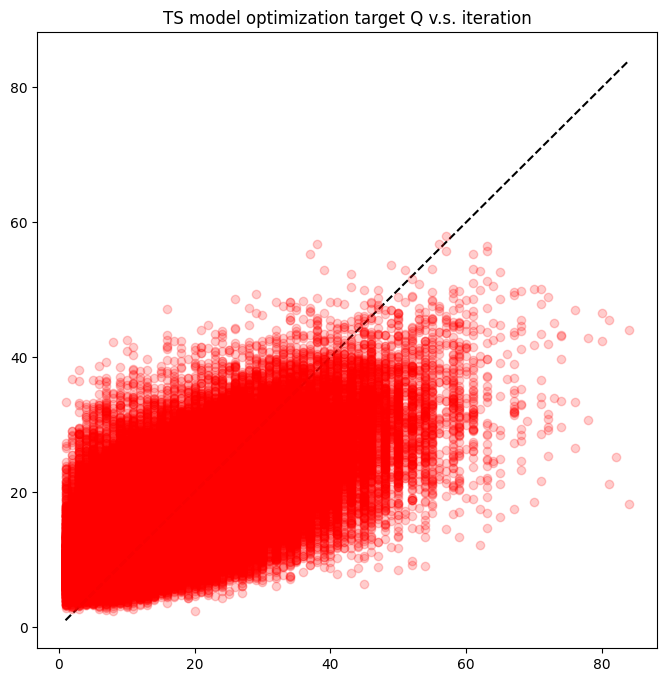

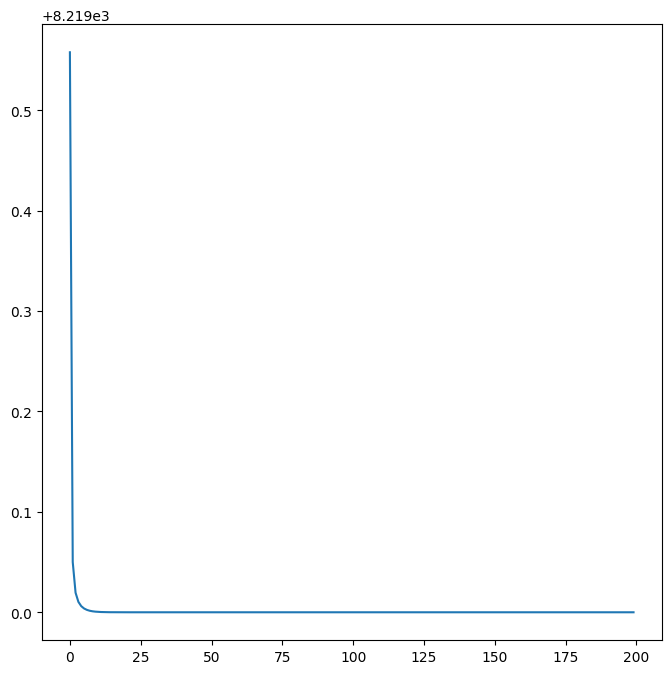

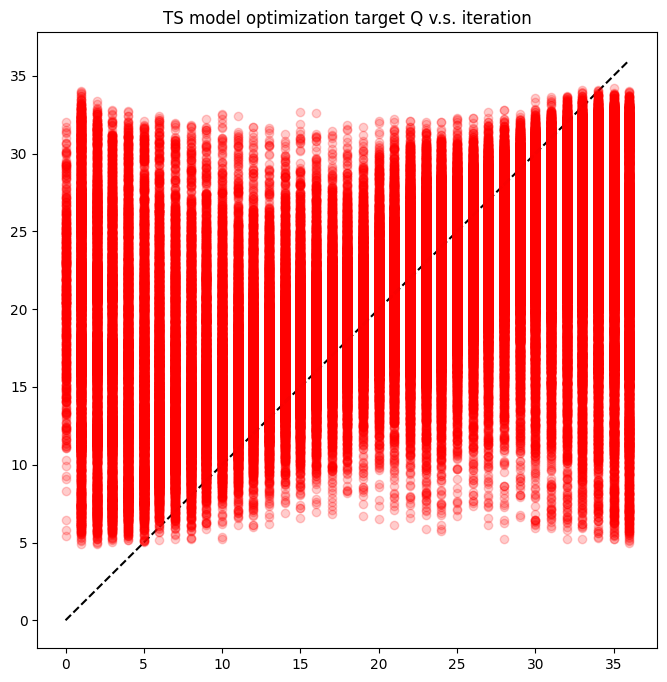

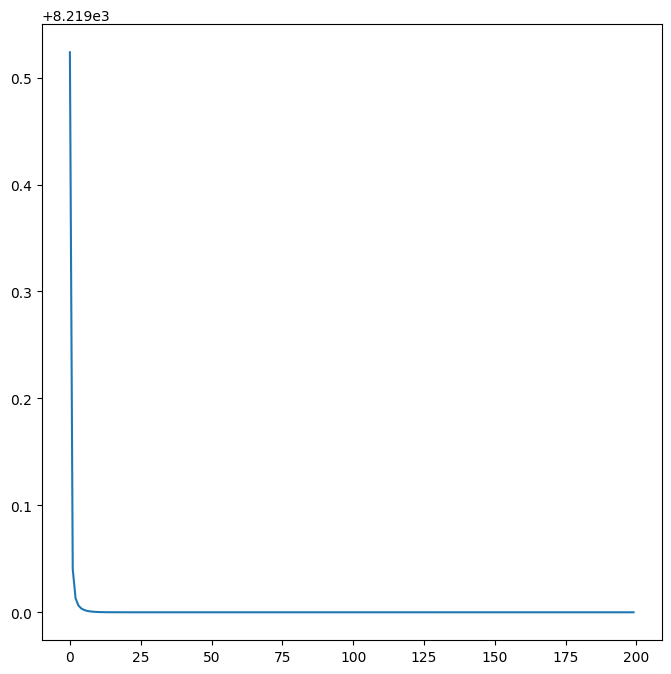

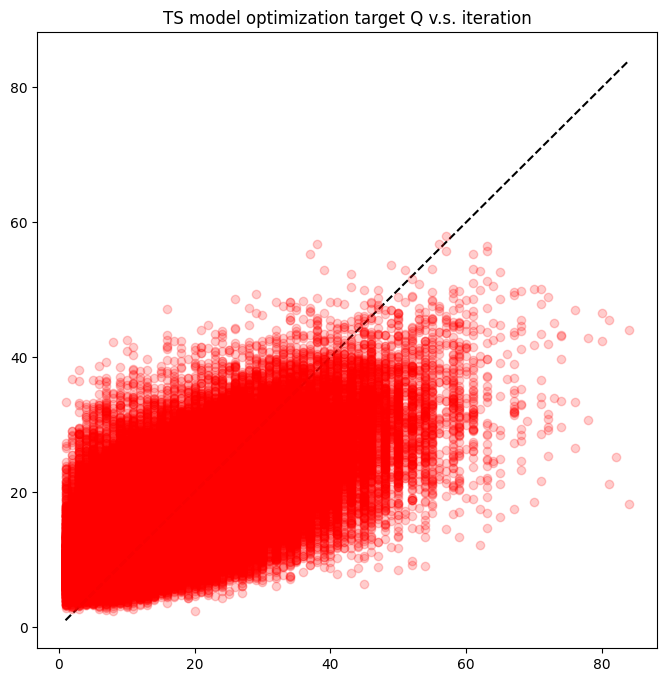

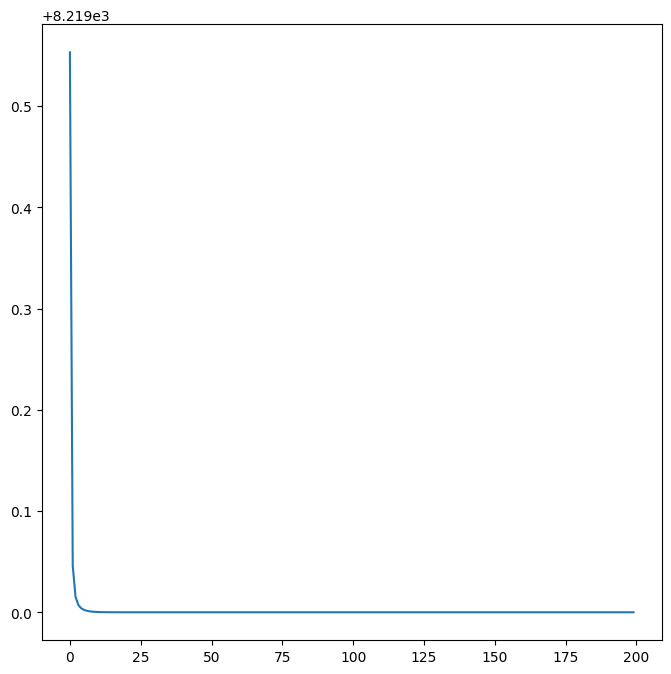

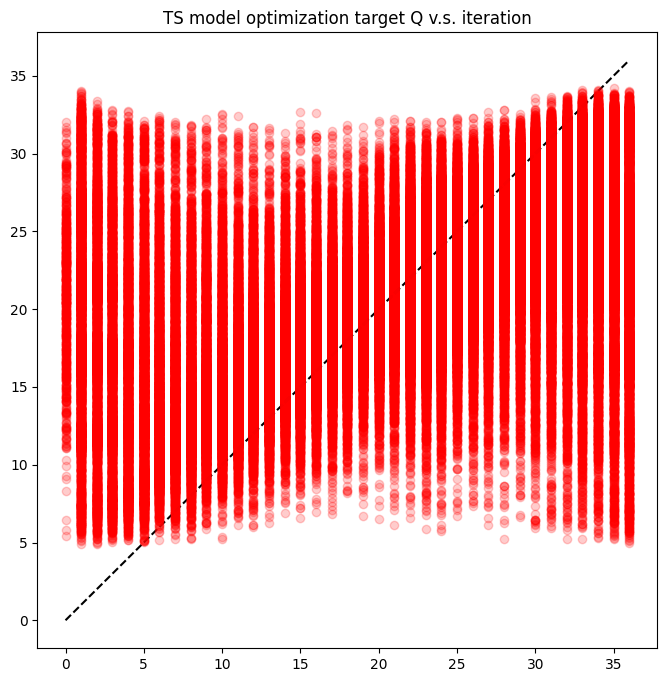

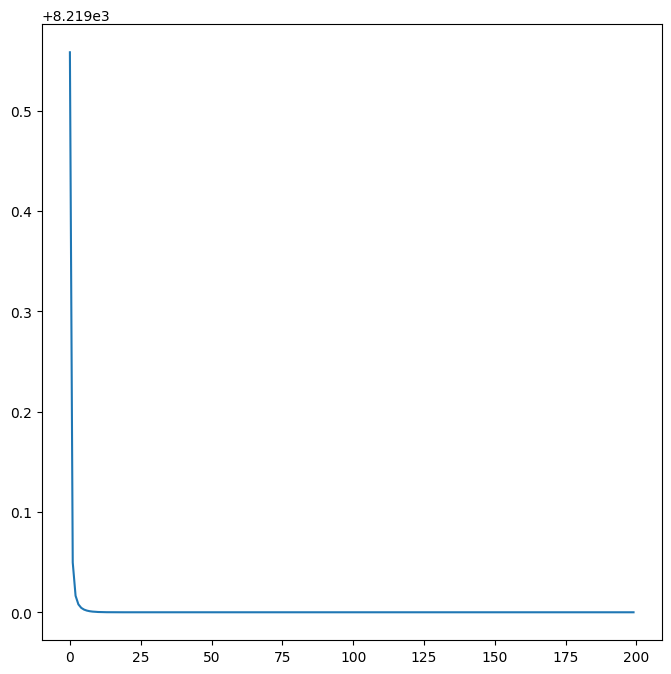

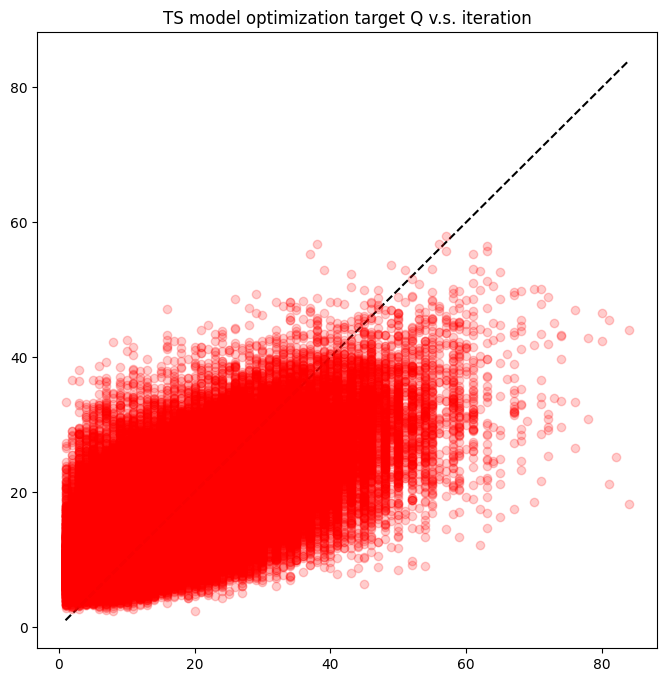

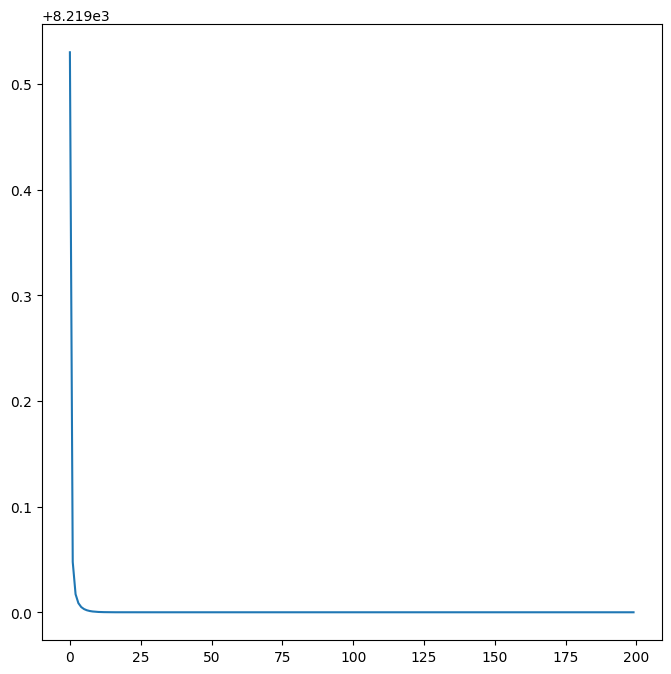

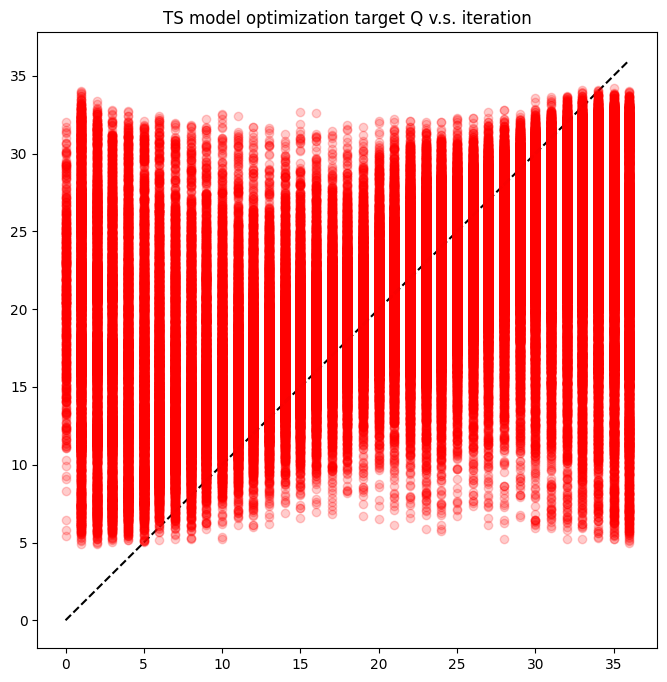

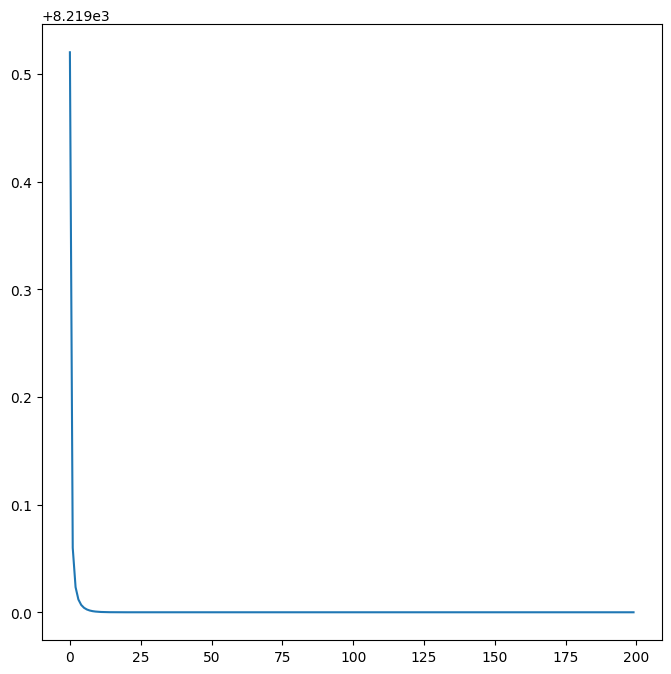

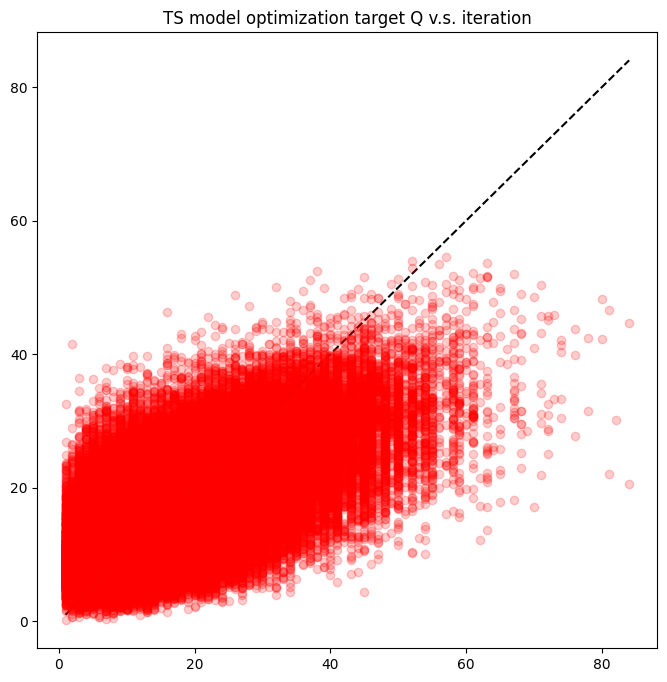

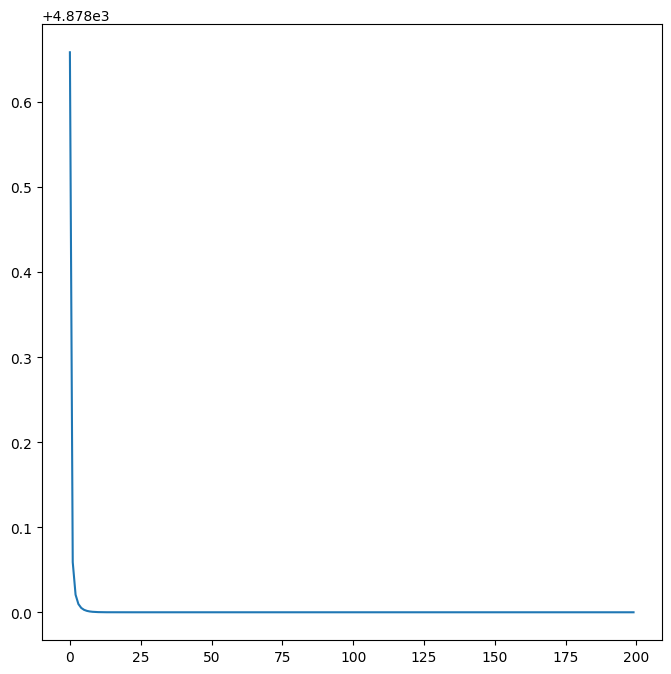

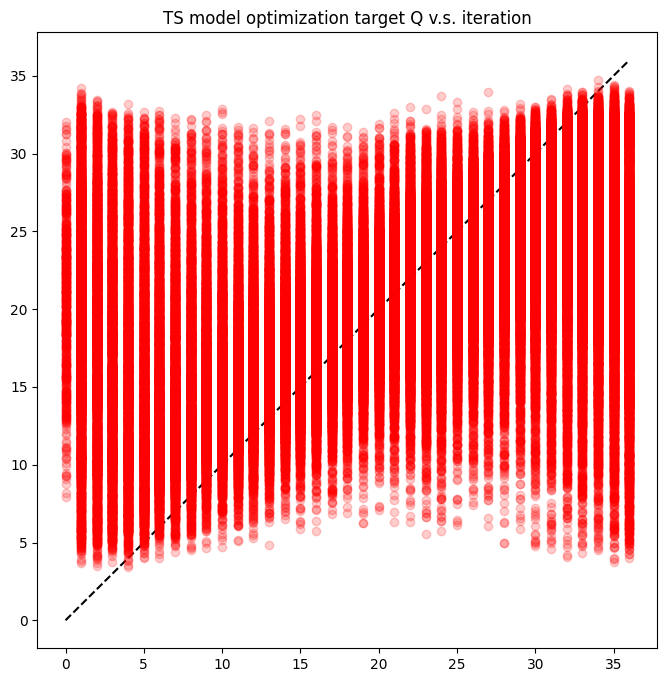

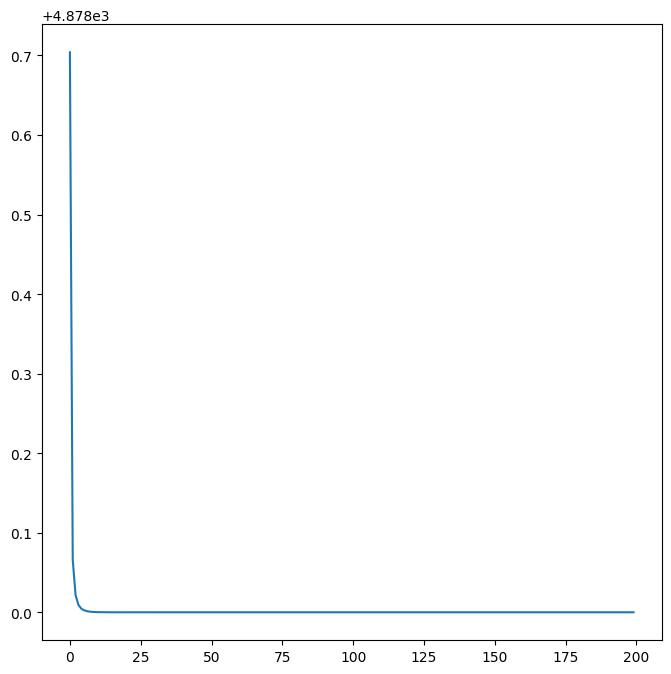

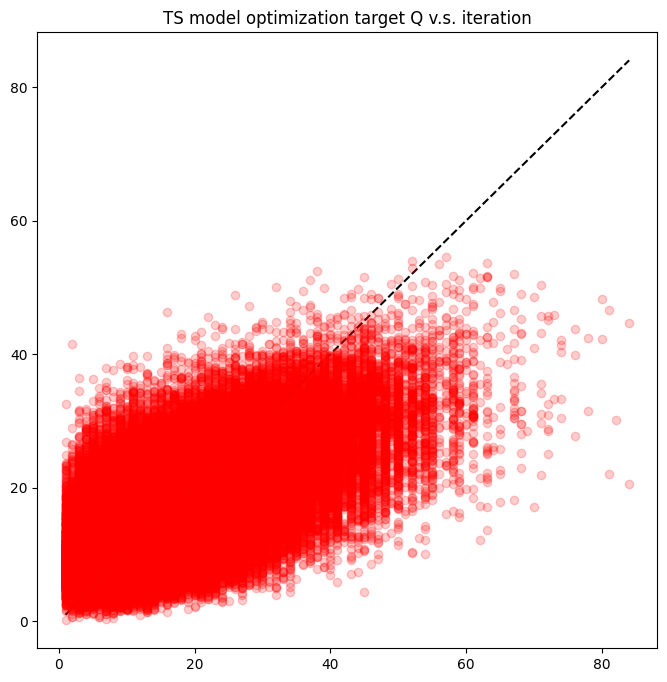

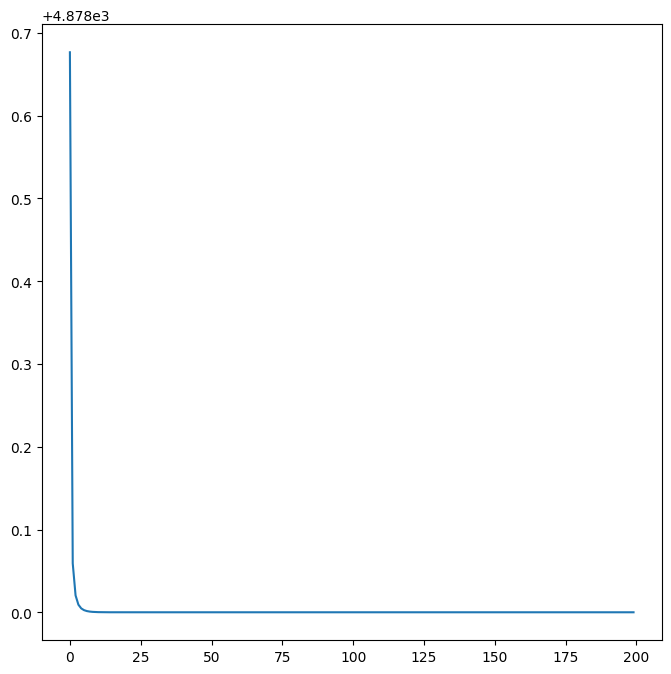

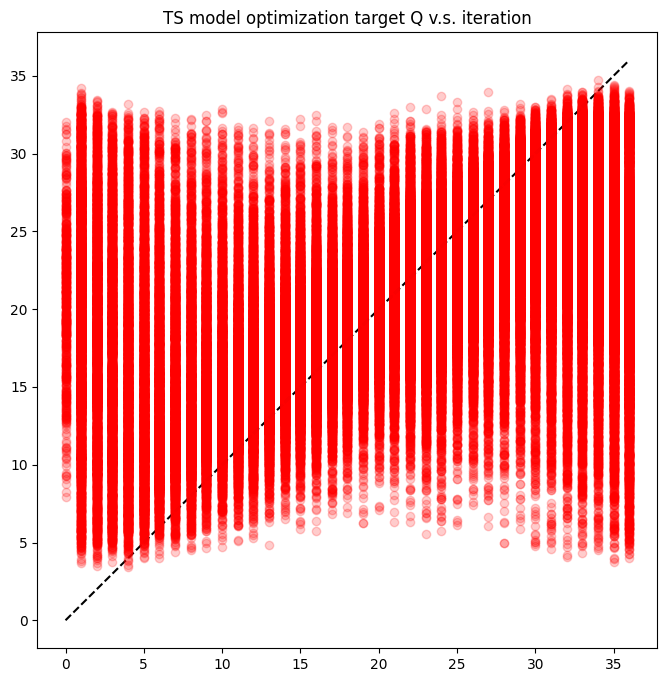

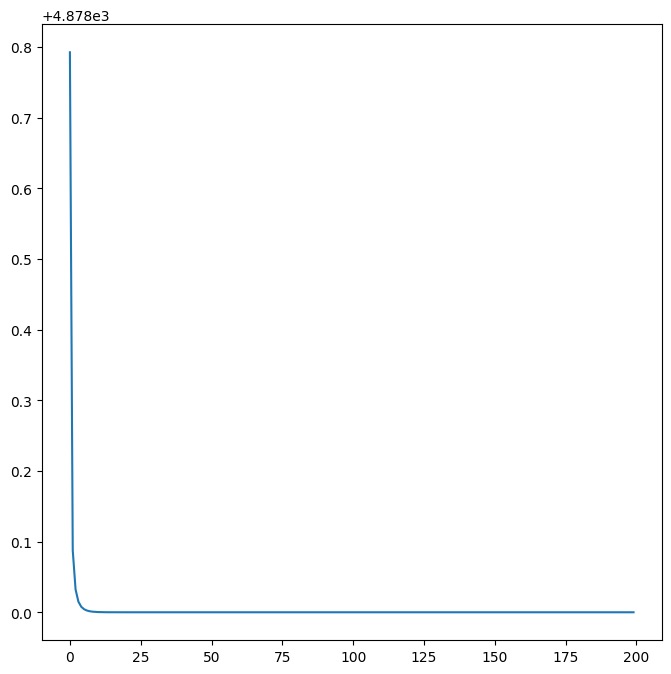

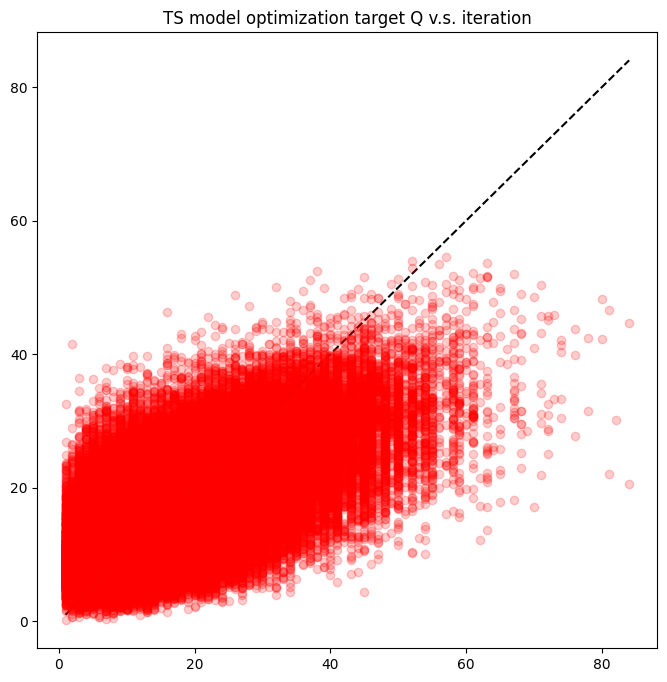

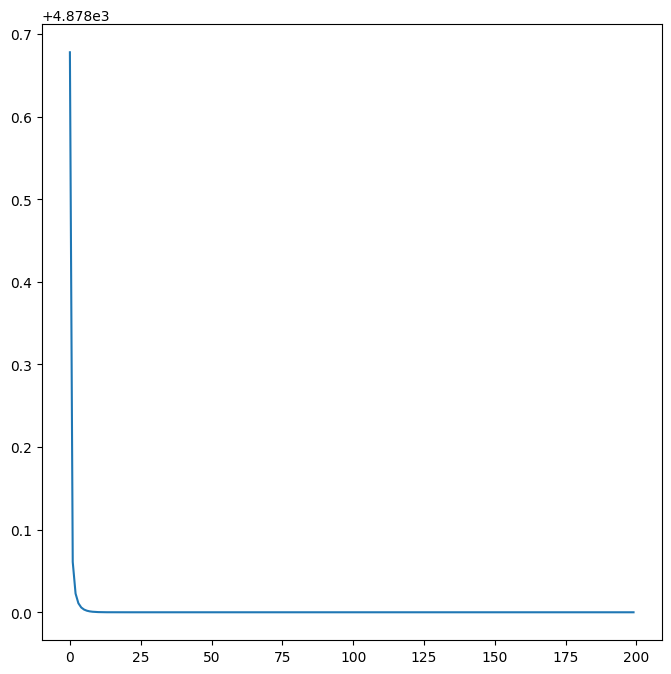

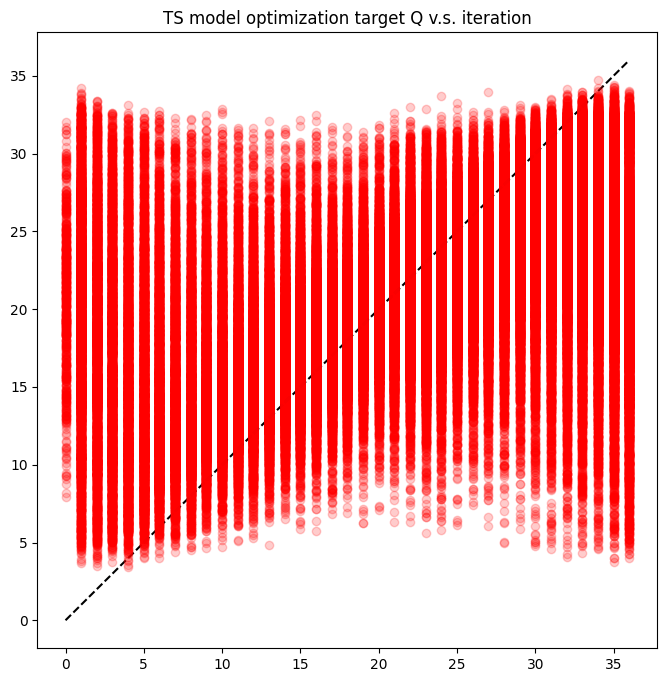

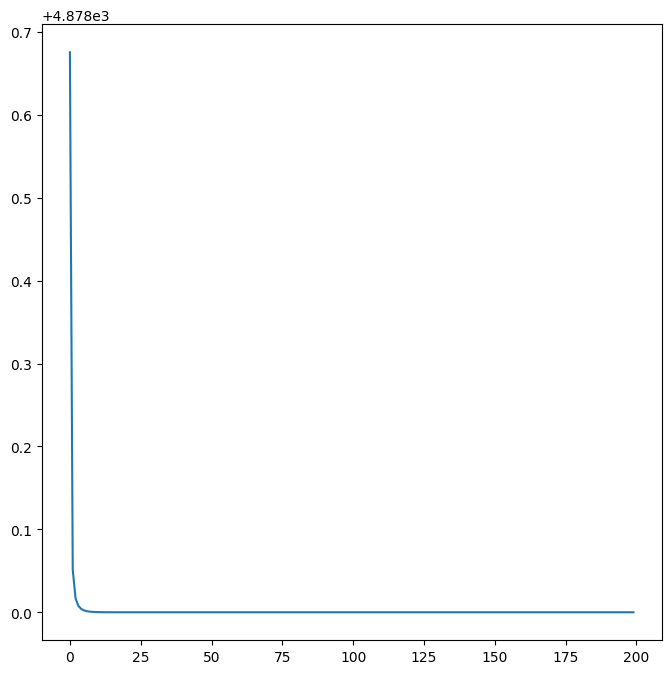

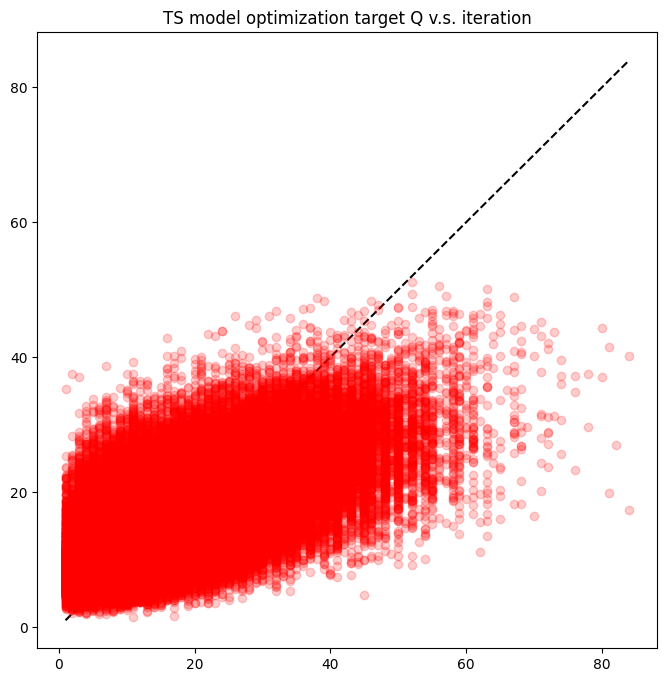

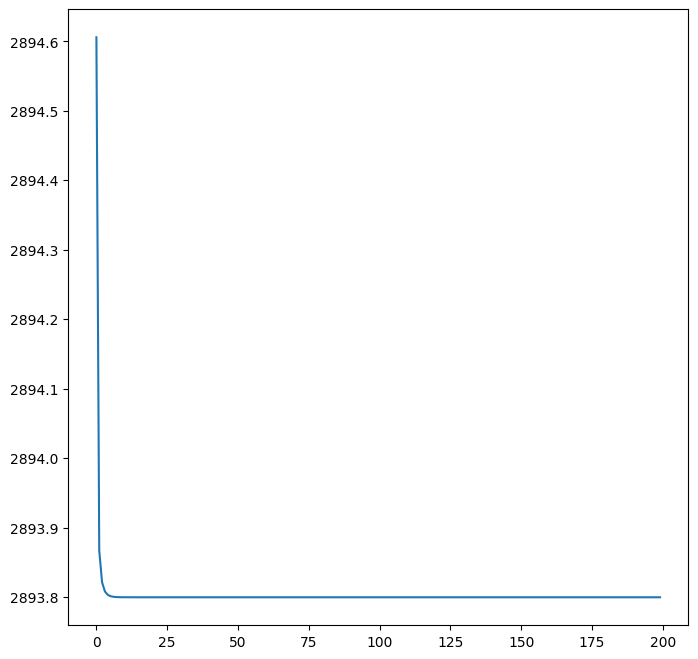

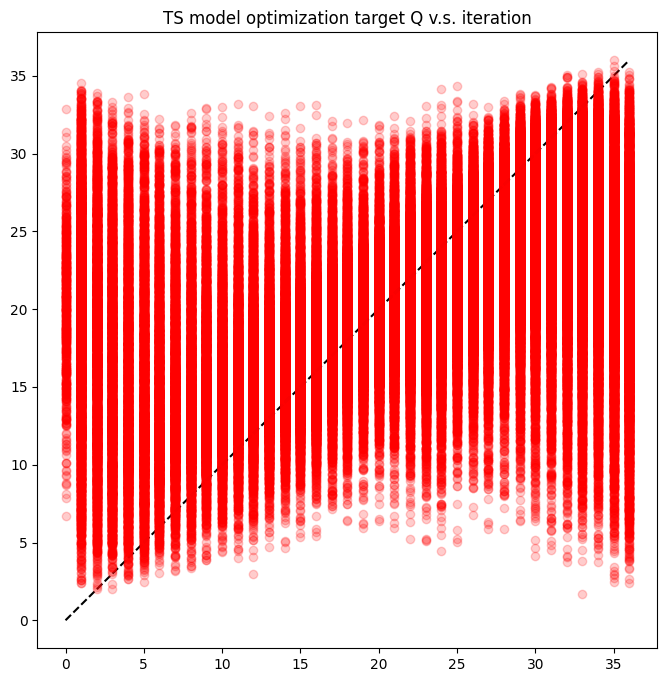

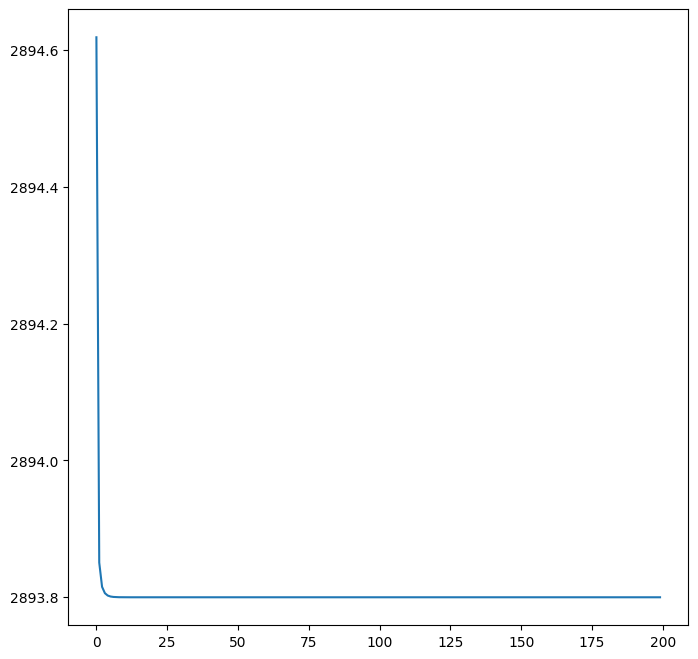

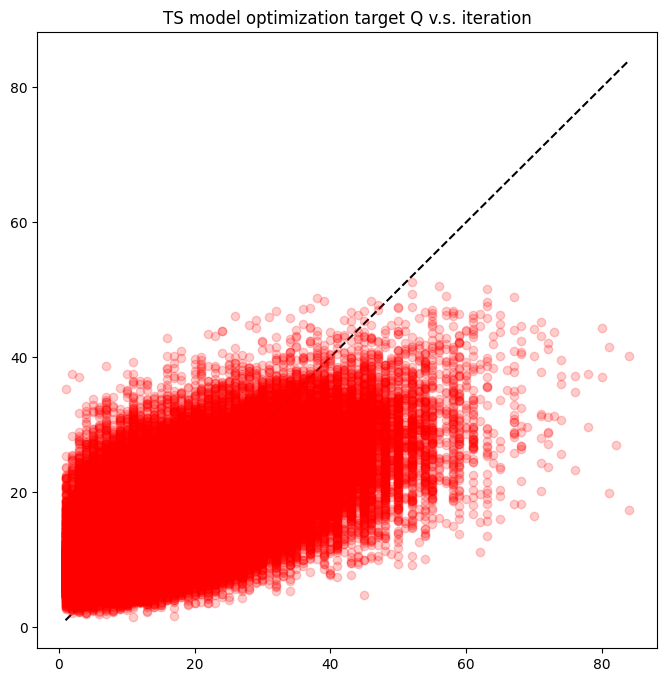

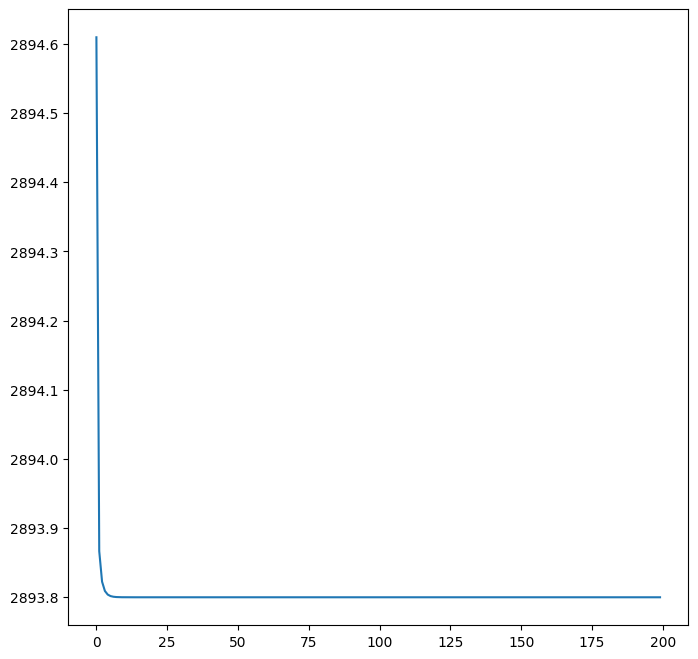

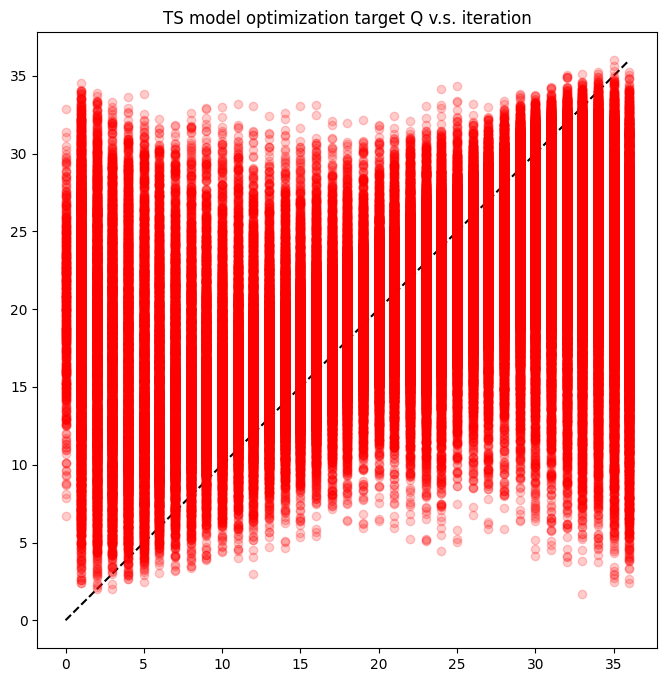

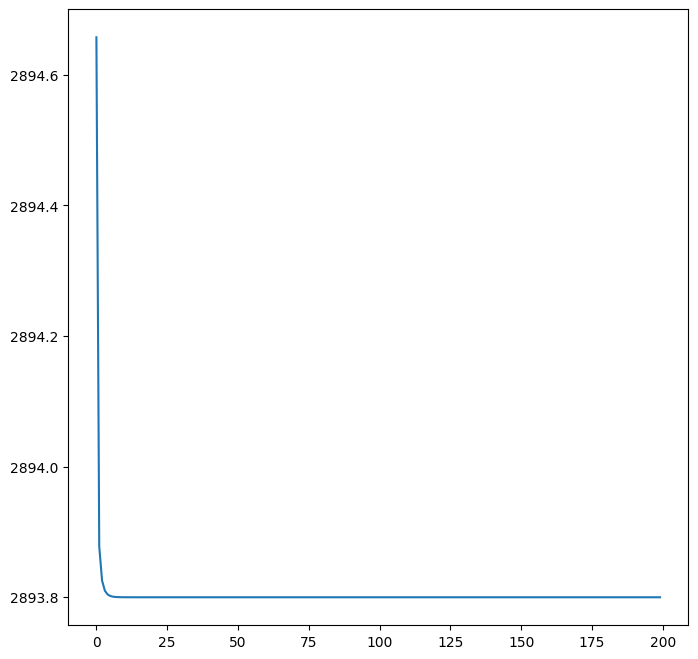

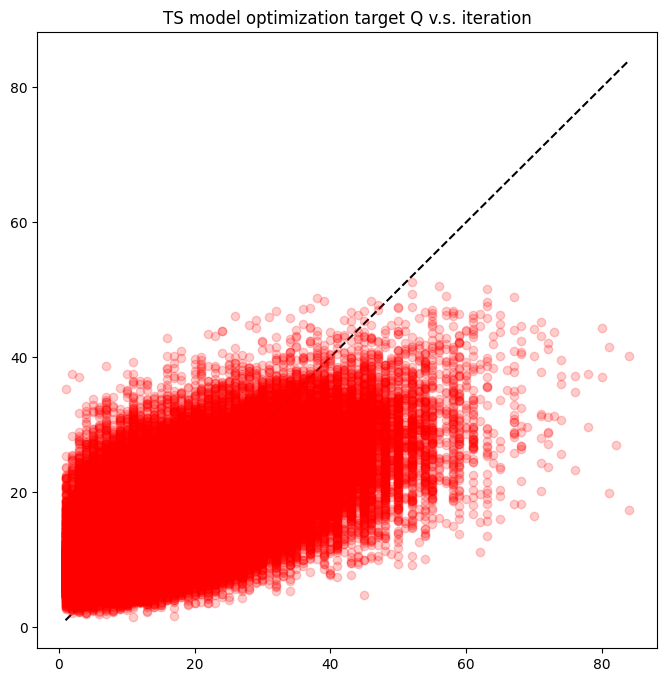

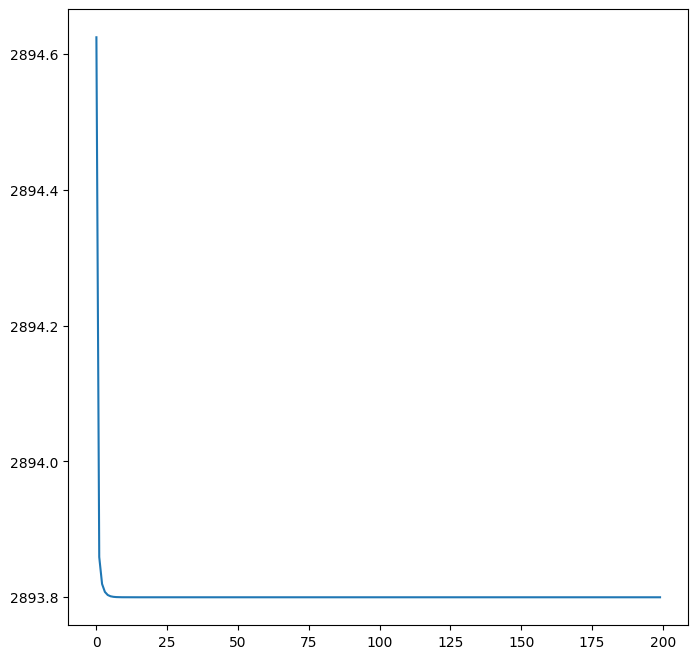

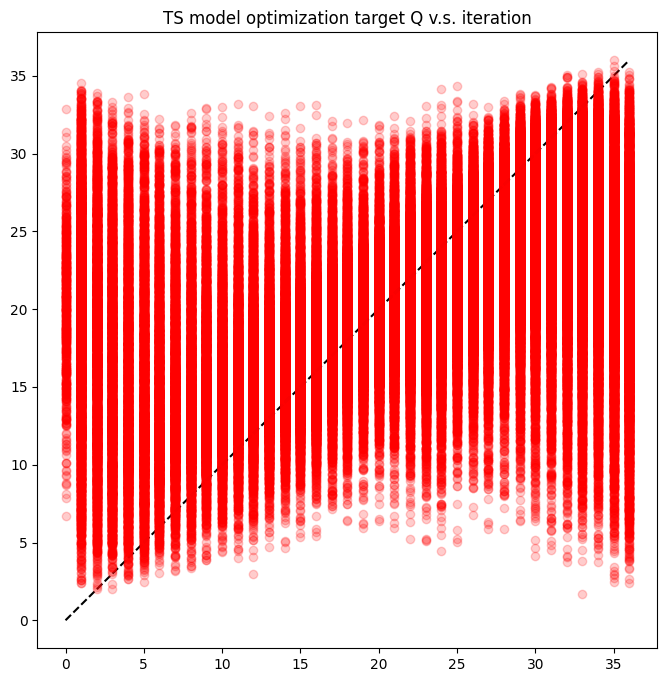

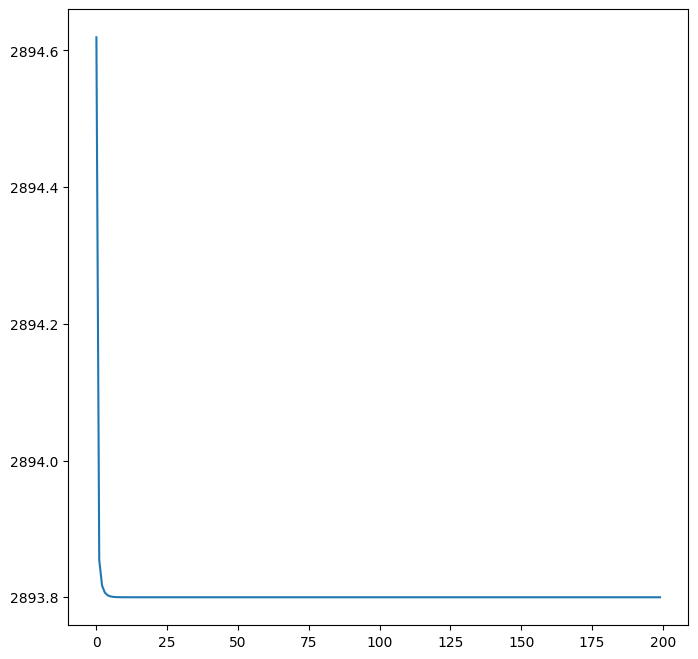

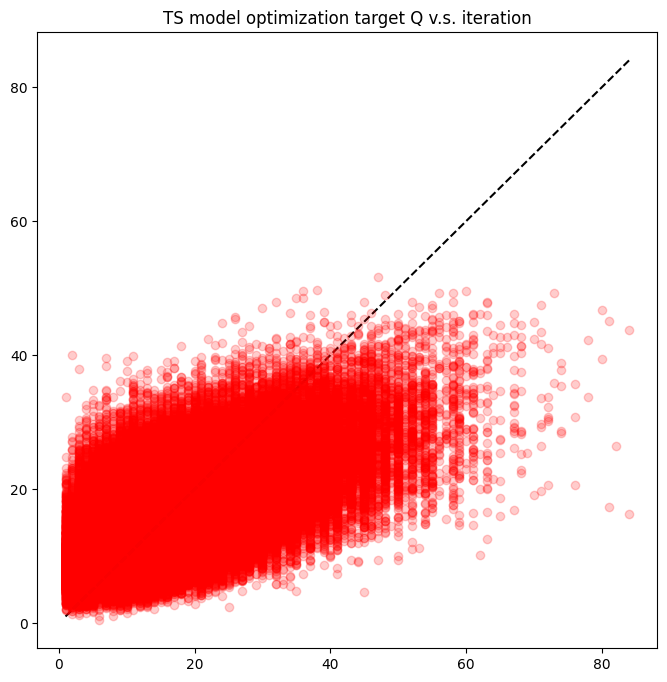

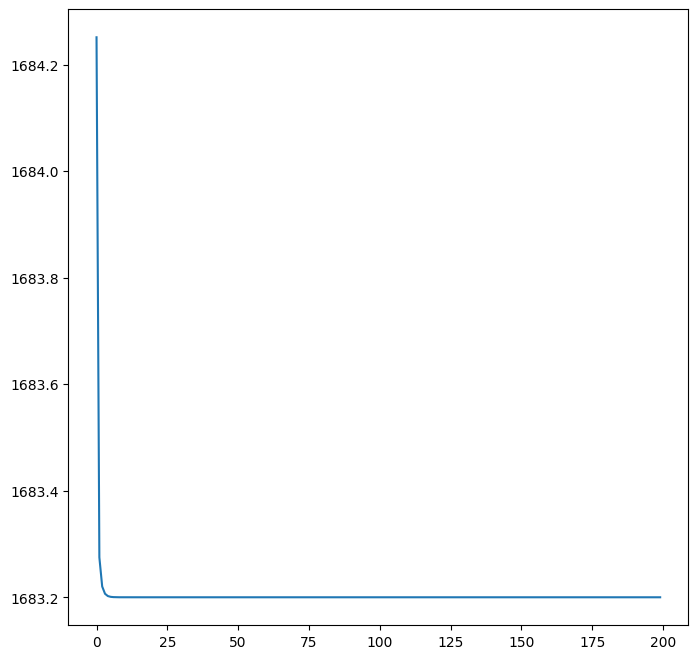

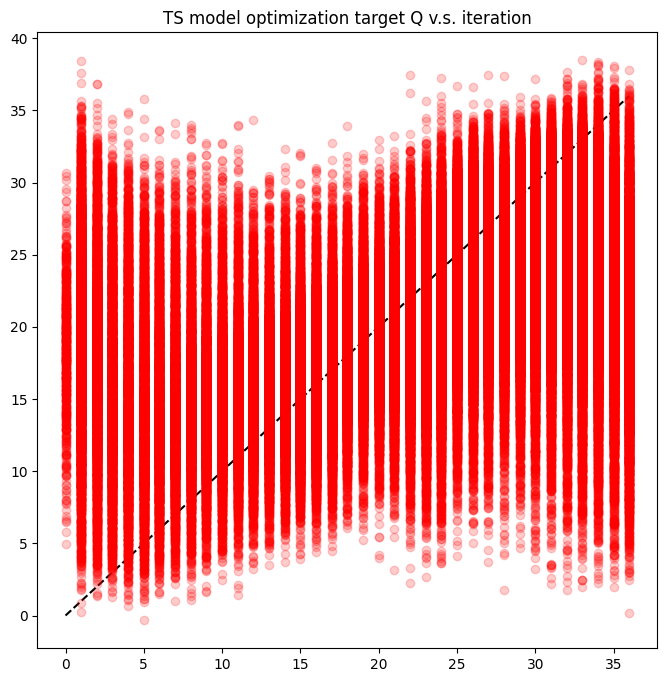

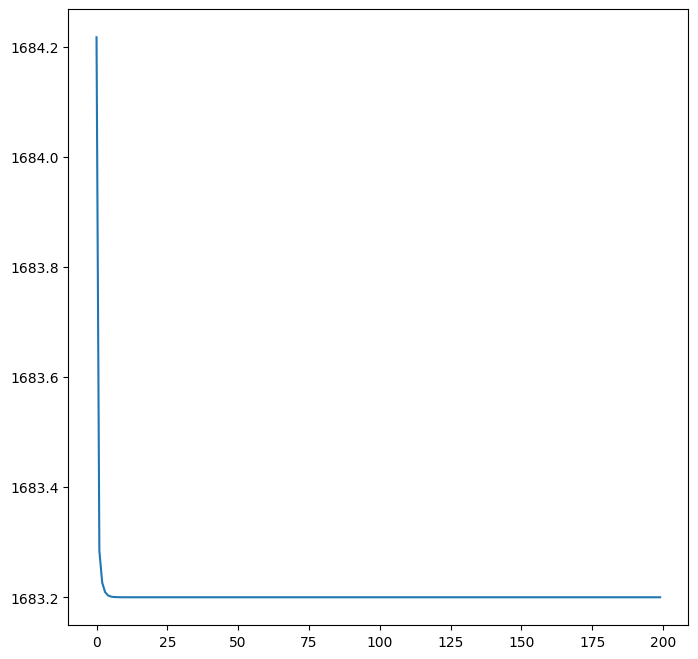

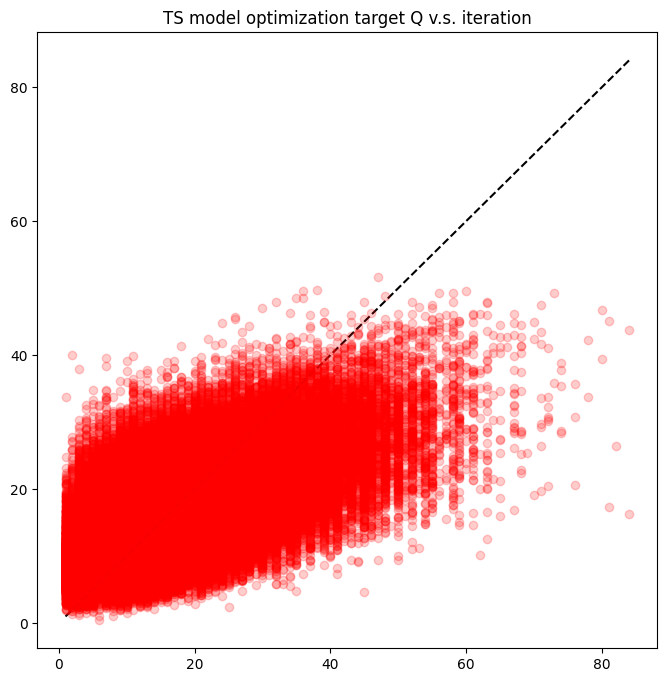

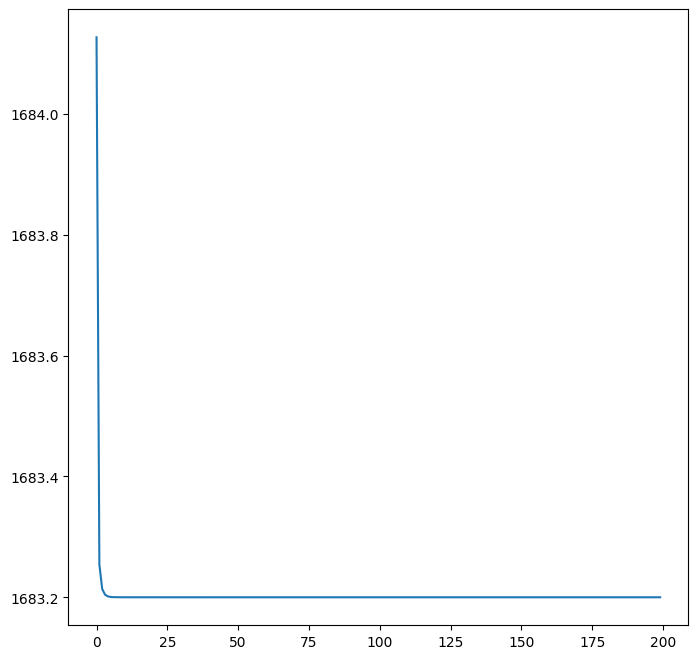

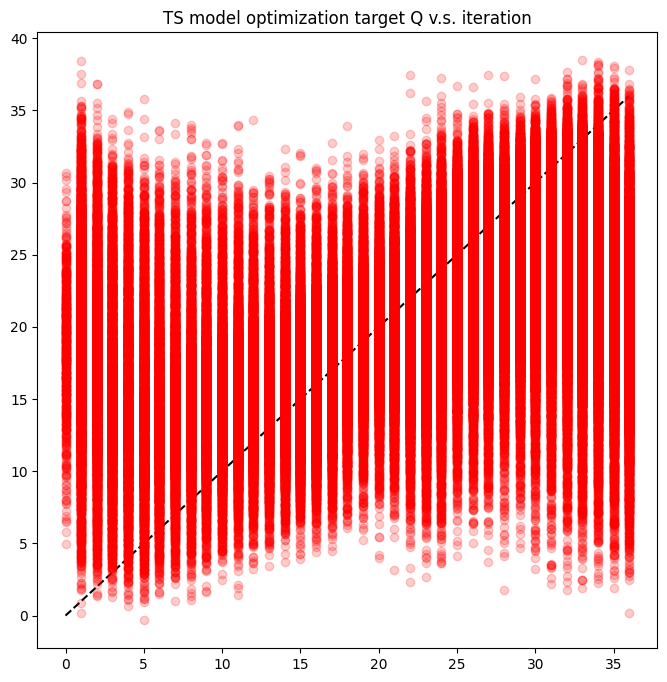

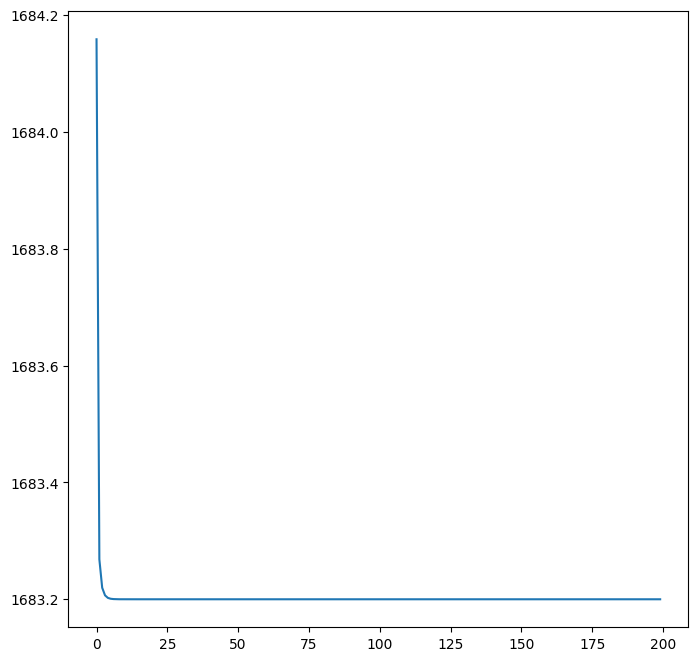

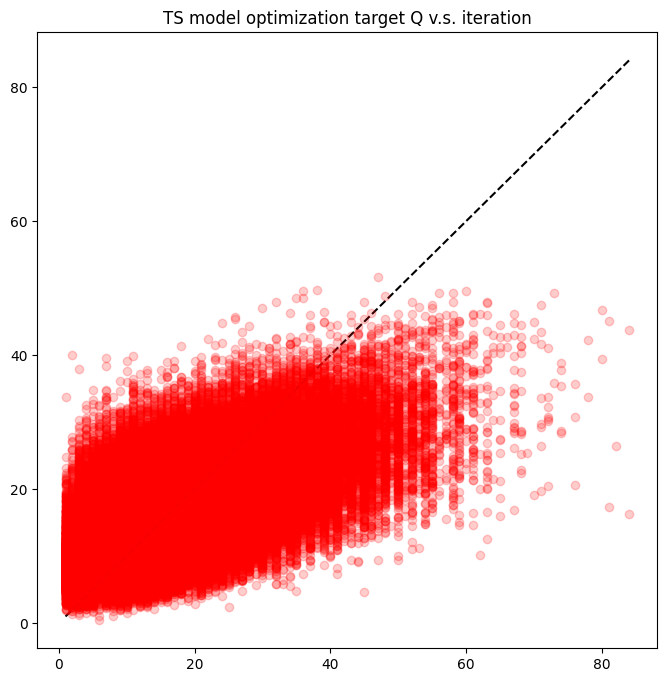

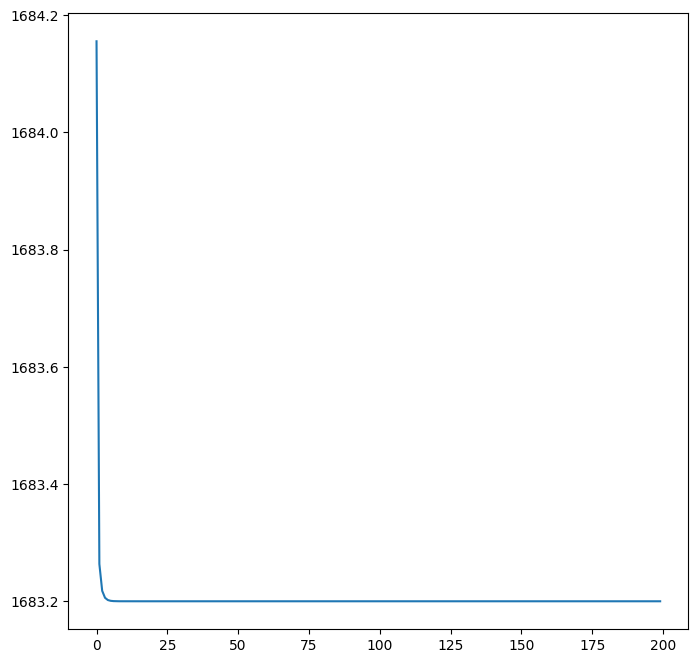

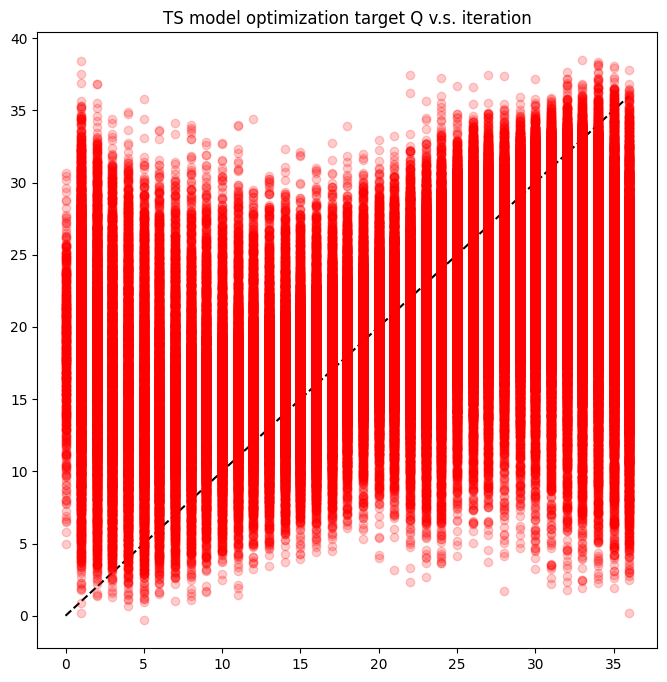

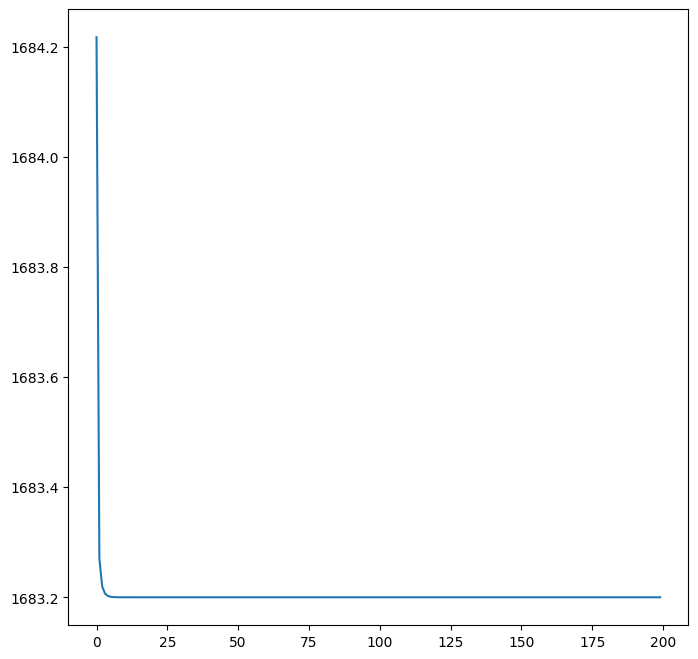

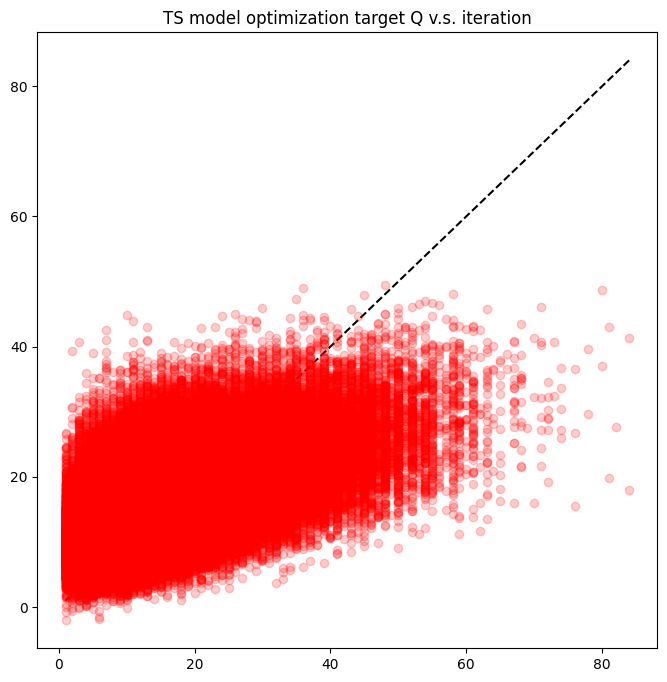

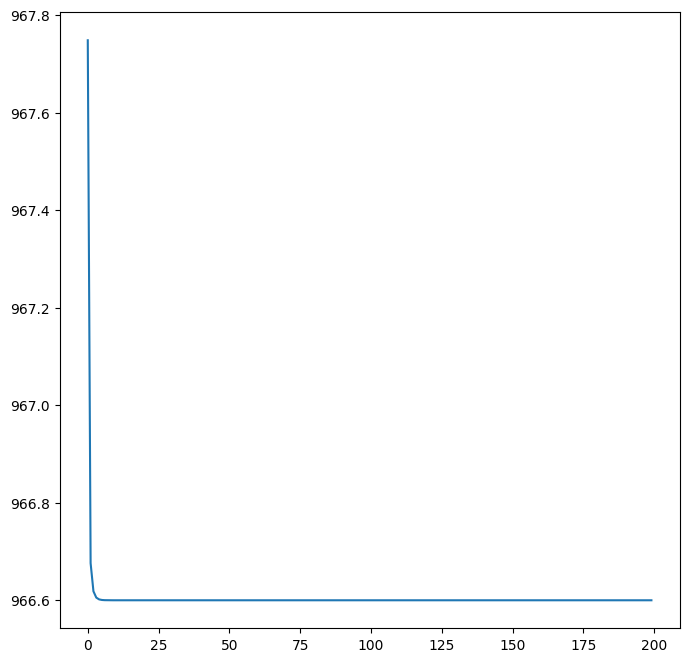

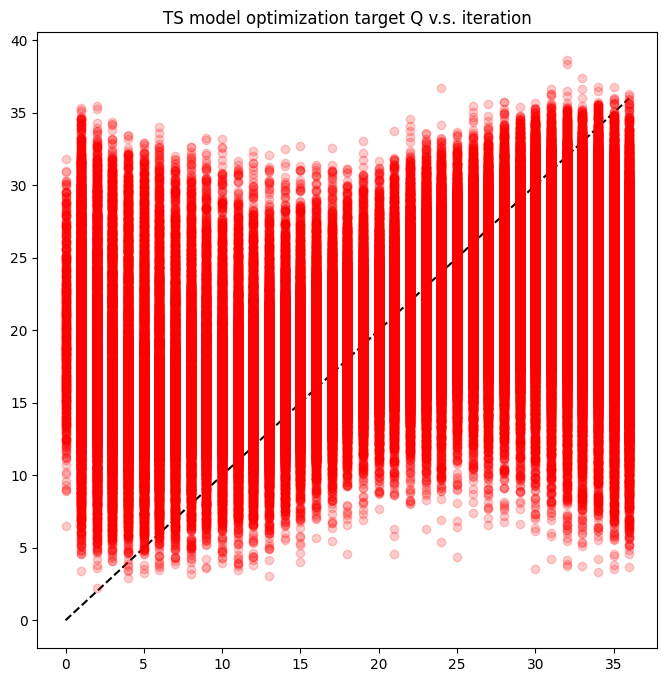

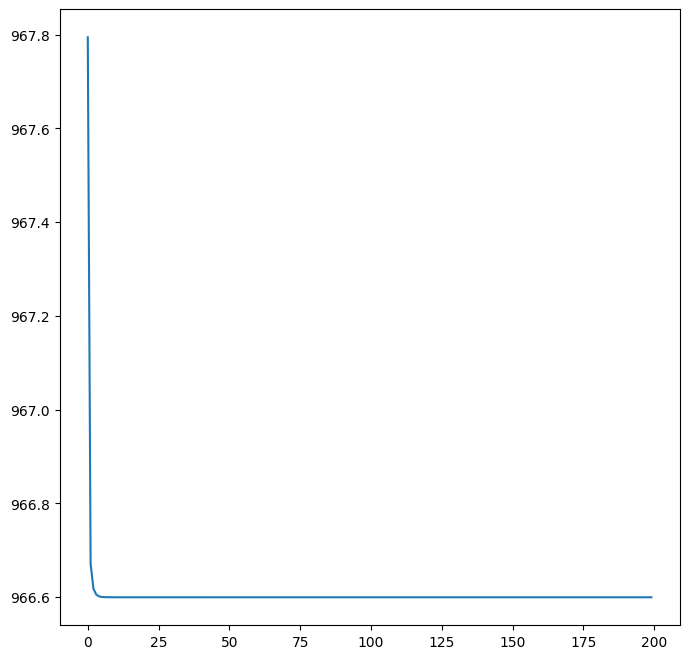

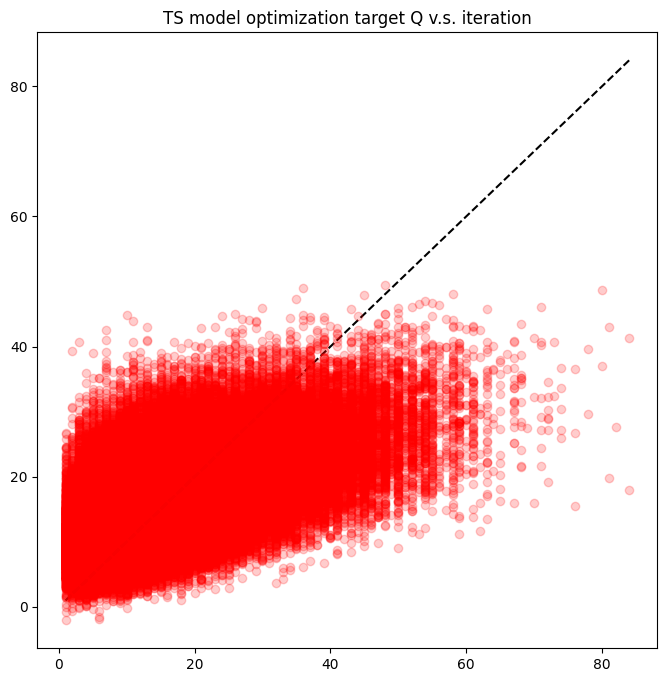

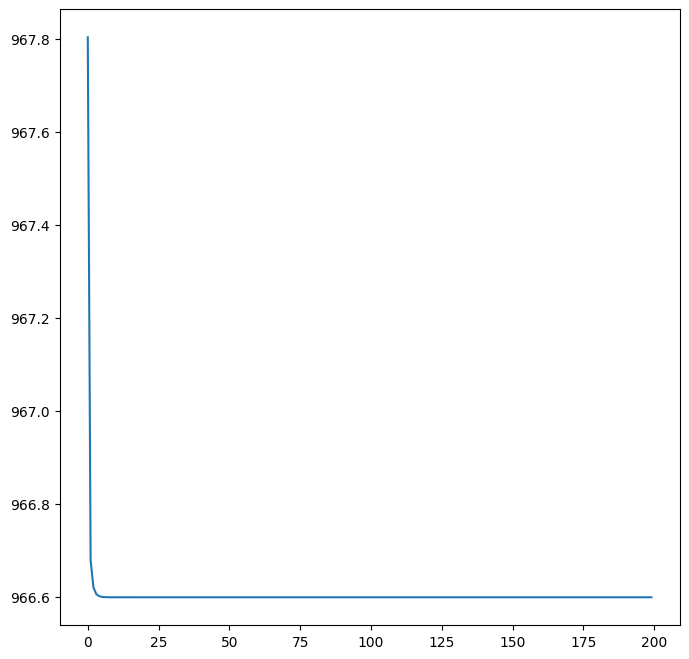

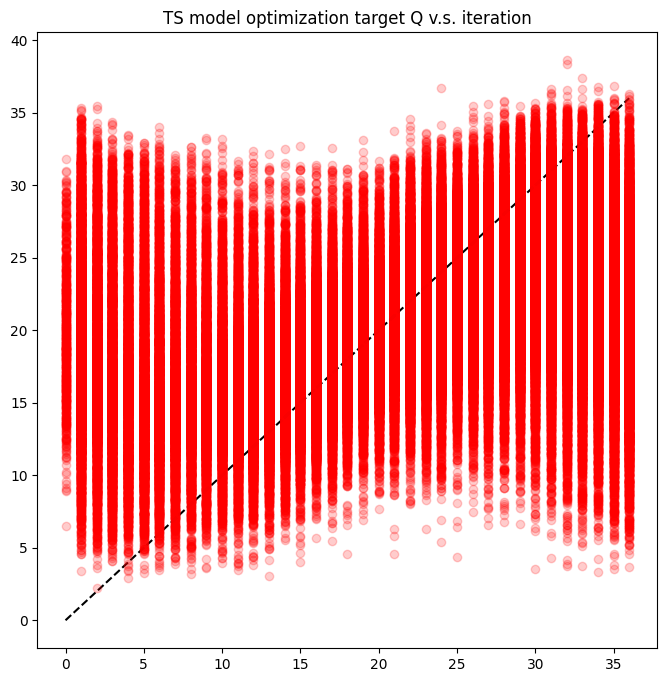

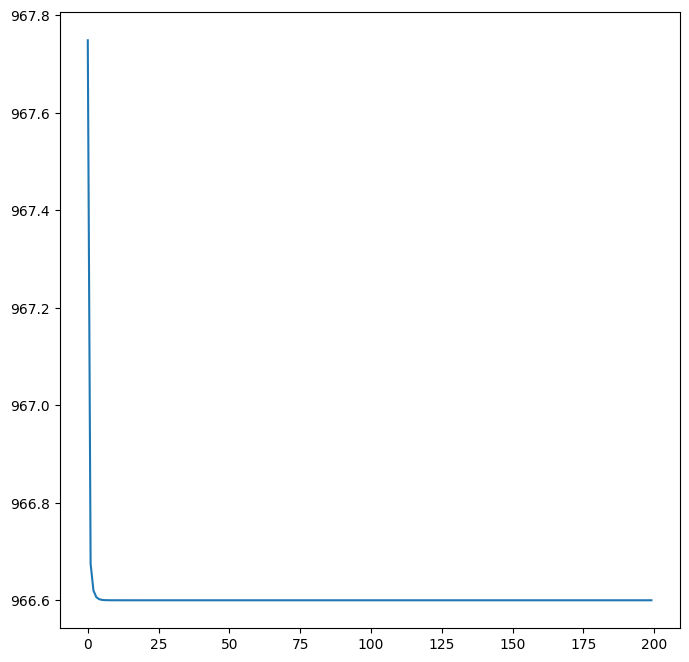

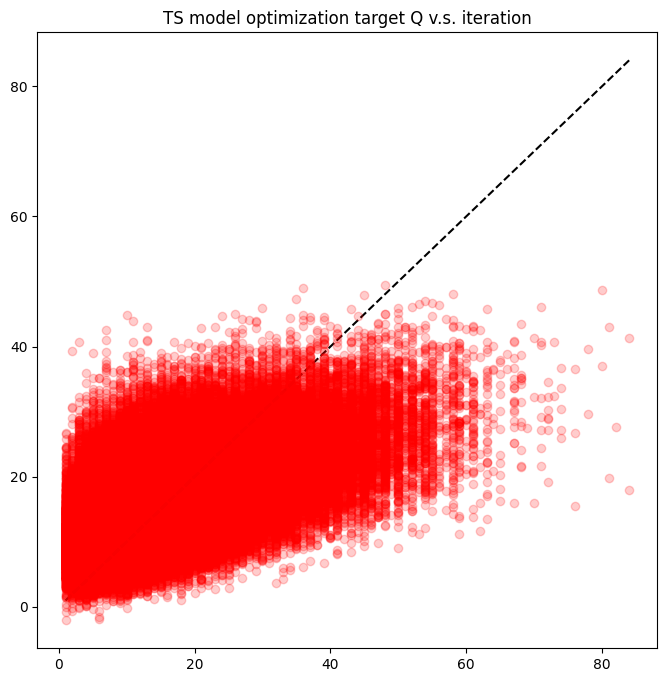

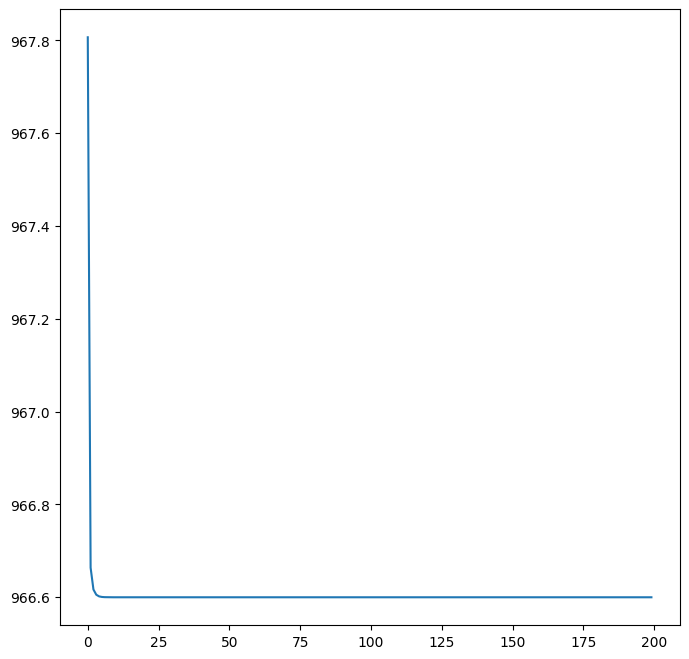

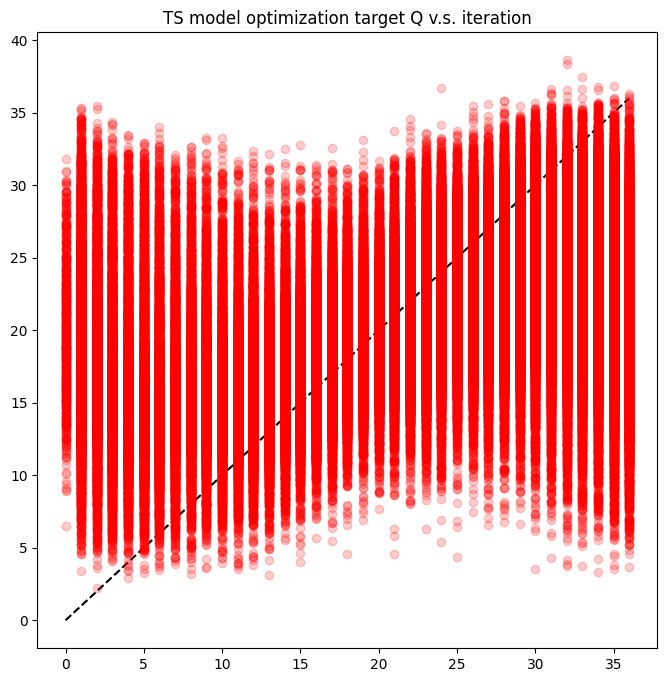

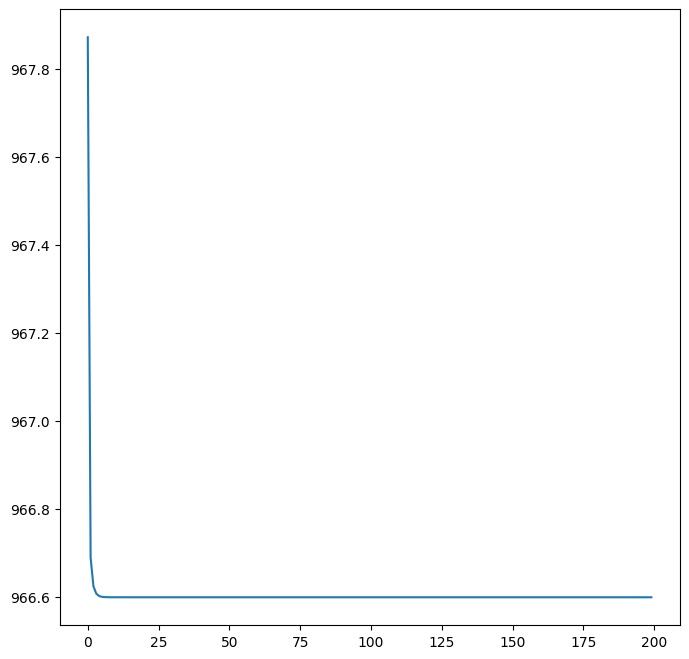

In [19]:
do_experiment(number_of_neighbour_stations, train_data, test_data)

exp
8.022500038146973±0.0
8.022500038146973±0.0
8.5143±0.0052
exp
7.940400123596191±0.0
7.940400123596191±0.0
9.1761±0.0567
exp
7.975800037384033±0.0
7.975800037384033±0.0
11.191±0.9216
exp
8.050399780273438±0.0
8.050399780273438±0.0
13.7209±0.2339
exp
8.195699691772461±0.0
8.195699691772461±0.0
18.5667±0.1969


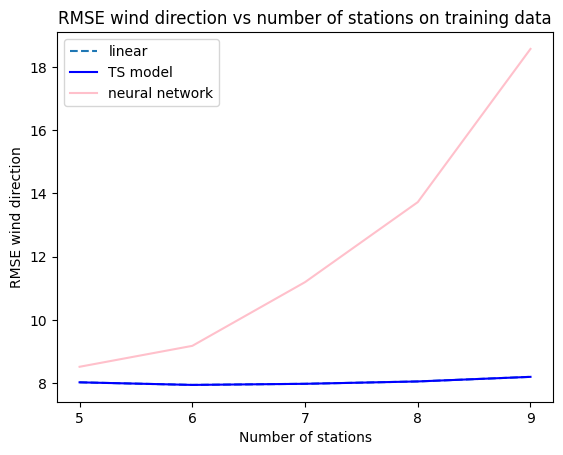

In [25]:
li_train_plot = []
fcm_train_plot = []
nn_train_plot = []
x_axis =  [5,6,7,8,9]
for exp in y2_training_results:
     li_train_plot.append(np.mean([d['linear_train'] for d in exp if 'linear_train' in d]))
     fcm_train_plot.append(np.mean([d['fcm_train'] for d in exp if 'fcm_train' in d]))
     nn_train_plot.append(np.mean([d['nn_train'] for d in exp if 'nn_train' in d]))

# insert the optimal value from previous experiments 
# li_train_plot.insert(1, 6.7202)
# fcm_train_plot.insert(1, 6.6459)
# nn_train_plot.insert(1, 5.8963)

fig, ax = plt.subplots()
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))
    
plt.plot(x_axis, li_train_plot, '--', label='linear')
plt.plot(x_axis, fcm_train_plot, label='TS model', c='blue')
plt.plot(x_axis, nn_train_plot, label='neural network', c='pink')
plt.legend(loc="upper left")
#plt.ylim(5)
plt.xlabel('Number of stations')
plt.ylabel('RMSE wind direction')
plt.title('RMSE wind direction vs number of stations on training data')

for exp in y2_training_results:
    print('exp')
    print(f"{np.round(np.mean([d['linear_train'] for d in exp if 'linear_train' in d]), 4)}±{np.round(np.std([d['linear_train'] for d in exp if 'linear_train' in d]),4)}")
    print(f"{np.round(np.mean([d['fcm_train'] for d in exp if 'fcm_train' in d]), 4)}±{np.round(np.std([d['fcm_train'] for d in exp if 'fcm_train' in d]),4)}")
    print(f"{np.round(np.mean([d['nn_train'] for d in exp if 'nn_train' in d]), 4)}±{np.round(np.std([d['nn_train'] for d in exp if 'nn_train' in d]),4)}")


exp
6.9816999435424805±0.0
6.9817±0.0
7.2844±0.0525
exp
6.999199867248535±0.0
6.9992±0.0
7.9886±0.076
exp
6.904699802398682±0.0
6.9047±0.0
9.7413±1.0535
exp
7.153900146484375±0.0
7.1539±0.0
11.3499±0.5211
exp
6.962600231170654±0.0
6.9626±0.0
13.931±0.4217


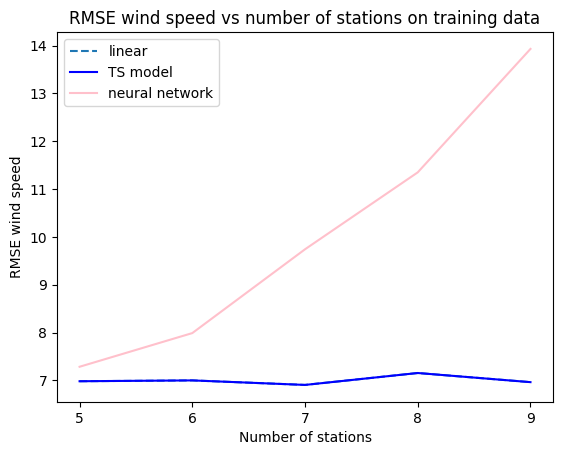

In [85]:
li_train_plot = []
fcm_train_plot = []
nn_train_plot = []
x_axis =  [5,6,7,8,9]
for exp in y1_training_results:
     li_train_plot.append(np.mean([d['linear_train'] for d in exp if 'linear_train' in d]))
     fcm_train_plot.append(np.mean([d['fcm_train'] for d in exp if 'fcm_train' in d]))
     nn_train_plot.append(np.mean([d['nn_train'] for d in exp if 'nn_train' in d]))

# insert the optimal value from previous experiments 
# li_train_plot.insert(1, 6.7202)
# fcm_train_plot.insert(1, 6.6459)
# nn_train_plot.insert(1, 5.8963)

fig, ax = plt.subplots()
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))
    
plt.plot(x_axis, li_train_plot, '--', label='linear')
plt.plot(x_axis, fcm_train_plot, label='TS model', c='blue')
plt.plot(x_axis, nn_train_plot, label='neural network', c='pink')
plt.legend(loc="upper left")
#plt.ylim(5)
plt.xlabel('Number of stations')
plt.ylabel('RMSE wind speed')
plt.title('RMSE wind speed vs number of stations on training data')

for exp in y1_training_results:
    print('exp')
    print(f"{np.round(np.mean([d['linear_train'] for d in exp if 'linear_train' in d]), 4)}±{np.round(np.std([d['linear_train'] for d in exp if 'linear_train' in d]),4)}")
    print(f"{np.round(np.mean([d['fcm_train'] for d in exp if 'fcm_train' in d]), 4)}±{np.round(np.std([d['fcm_train'] for d in exp if 'fcm_train' in d]),4)}")
    print(f"{np.round(np.mean([d['nn_train'] for d in exp if 'nn_train' in d]), 4)}±{np.round(np.std([d['nn_train'] for d in exp if 'nn_train' in d]),4)}")


exp
8.091699600219727±0.0
8.0917±0.0
10.0105±0.01
exp
8.137499809265137±0.0
8.1375±0.0
10.5008±0.0564
exp
8.277700424194336±0.0
8.2777±0.0
11.8181±0.9905
exp
8.626500129699707±0.0
8.6263±0.0004
13.2871±0.2114
exp
8.75879955291748±0.0
8.7588±0.0002
17.0021±0.3905


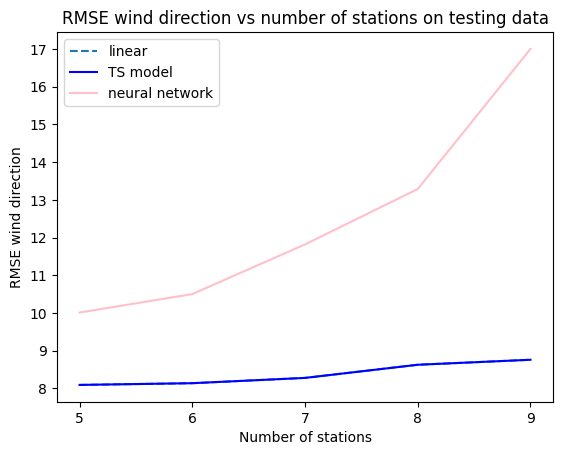

In [24]:
li_train_plot = []
fcm_train_plot = []
nn_train_plot = []
x_axis =  [5,6,7,8,9]
for exp in y2_test_results:
     li_train_plot.append(np.mean([d['linear_test'] for d in exp if 'linear_test' in d]))
     fcm_train_plot.append(np.mean([d['fcm_test'] for d in exp if 'fcm_test' in d]))
     nn_train_plot.append(np.mean([d['nn_test'] for d in exp if 'nn_test' in d]))

fig, ax = plt.subplots()
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))

# insert the optimal value from previous experiments 
# li_train_plot.insert(1, 6.7219)
# fcm_train_plot.insert(1, 6.6489)
# nn_train_plot.insert(1, 5.9011)


plt.plot(x_axis, li_train_plot, '--', label='linear')
plt.plot(x_axis, fcm_train_plot, label='TS model', c='blue')
plt.plot(x_axis, nn_train_plot, label='neural network', c='pink')
plt.legend(loc="upper left")
#plt.ylim(5)
plt.xlabel('Number of stations')
plt.ylabel('RMSE wind direction')
plt.title('RMSE wind direction vs number of stations on testing data')

for exp in y2_test_results:
    print('exp')
    print(f"{np.round(np.mean([d['linear_test'] for d in exp if 'linear_test' in d]), 4)}±{np.round(np.std([d['linear_test'] for d in exp if 'linear_test' in d]),4)}")
    print(f"{np.round(np.mean([d['fcm_test'] for d in exp if 'fcm_test' in d]), 4)}±{np.round(np.std([d['fcm_test'] for d in exp if 'fcm_test' in d]),4)}")
    print(f"{np.round(np.mean([d['nn_test'] for d in exp if 'nn_test' in d]), 4)}±{np.round(np.std([d['nn_test'] for d in exp if 'nn_test' in d]),4)}")


exp
6.962900161743164±0.0
6.9629±0.0
10.0944±0.0166
exp
7.059899806976318±0.0
7.0599±0.0
10.6813±0.0732
exp
7.165500164031982±0.0
7.1655±0.0
12.6473±1.6619
exp
7.315700054168701±0.0
7.3157±0.0
13.7266±0.5879
exp
7.814799785614014±0.0
7.8149±0.0002
17.2916±0.6844


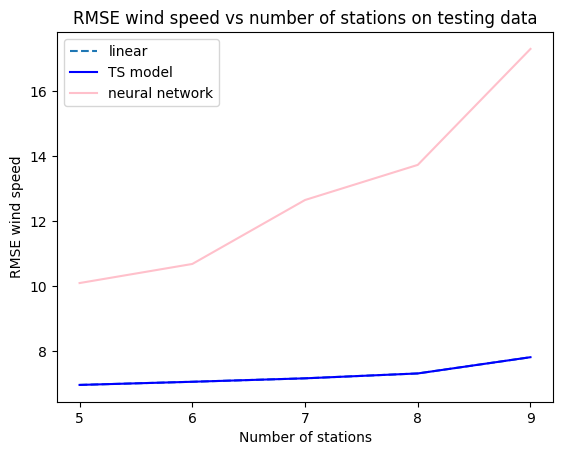

In [88]:
li_train_plot = []
fcm_train_plot = []
nn_train_plot = []
x_axis =  [5,6,7,8,9]
for exp in y1_test_results:
     li_train_plot.append(np.mean([d['linear_test'] for d in exp if 'linear_test' in d]))
     fcm_train_plot.append(np.mean([d['fcm_test'] for d in exp if 'fcm_test' in d]))
     nn_train_plot.append(np.mean([d['nn_test'] for d in exp if 'nn_test' in d]))

fig, ax = plt.subplots()
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))

# insert the optimal value from previous experiments 
# li_train_plot.insert(1, 6.7219)
# fcm_train_plot.insert(1, 6.6489)
# nn_train_plot.insert(1, 5.9011)


plt.plot(x_axis, li_train_plot, '--', label='linear')
plt.plot(x_axis, fcm_train_plot, label='TS model', c='blue')
plt.plot(x_axis, nn_train_plot, label='neural network', c='pink')
plt.legend(loc="upper left")
#plt.ylim(5)
plt.xlabel('Number of stations')
plt.ylabel('RMSE wind speed')
plt.title('RMSE wind speed vs number of stations on testing data')

for exp in y1_test_results:
    print('exp')
    print(f"{np.round(np.mean([d['linear_test'] for d in exp if 'linear_test' in d]), 4)}±{np.round(np.std([d['linear_test'] for d in exp if 'linear_test' in d]),4)}")
    print(f"{np.round(np.mean([d['fcm_test'] for d in exp if 'fcm_test' in d]), 4)}±{np.round(np.std([d['fcm_test'] for d in exp if 'fcm_test' in d]),4)}")
    print(f"{np.round(np.mean([d['nn_test'] for d in exp if 'nn_test' in d]), 4)}±{np.round(np.std([d['nn_test'] for d in exp if 'nn_test' in d]),4)}")


[0.005939881006876628, 0.005647897720336914, 0.0062258243560791016, 0.006314992904663086, 0.008602619171142578]
[5.453493595123291, 3.4110570748647056, 2.858502229054769, 2.5265867710113525, 3.076847791671753]
[414.46724541982013, 415.56555851300556, 417.3873558839162, 391.0437972545624, 408.78425709406537]


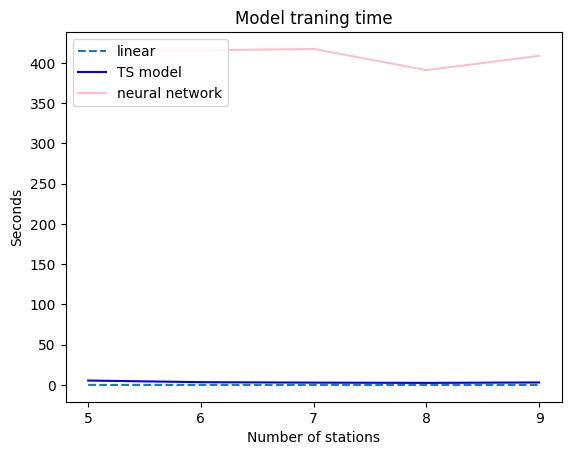

In [75]:
li_time_plot = []
fcm_time_plot = []
nn_time_plot = []
x_axis =  [5,6,7,8,9]
for exp in training_times:
    li_time_plot.append(np.mean([d['linear_train'] for d in exp if 'linear_train' in d]))
    fcm_time_plot.append(np.mean([d['fcm_train'] for d in exp if 'fcm_train' in d]))
    nn_time_plot.append(np.mean([d['nn_train'] for d in exp if 'nn_train' in d]))

fig, ax = plt.subplots()
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))
    
plt.plot(x_axis, li_time_plot, '--', label='linear')
plt.plot(x_axis, fcm_time_plot, label='TS model', c='blue')
plt.plot(x_axis, nn_time_plot, label='neural network', c='pink')
plt.legend(loc="upper left")
plt.xlabel('Number of stations')
plt.ylabel('Seconds')
plt.title('Model traning time')

print(li_time_plot)
print(fcm_time_plot)
print(nn_time_plot)

Text(0.5, 1.0, 'Loss vs number of epoches')

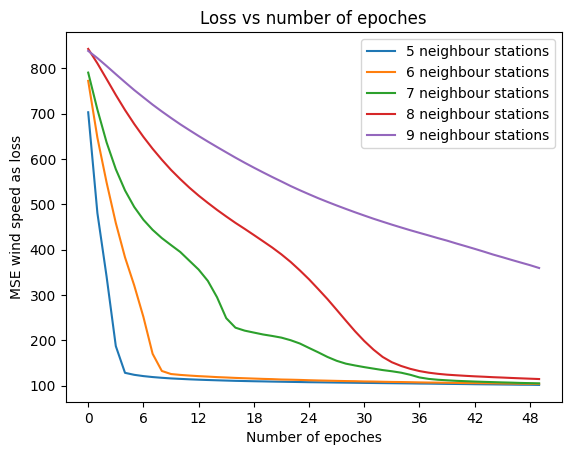

In [77]:
i = 1
fig, ax = plt.subplots()
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))

for exp in nn_histories:
    nn_losses = []
    for fold in exp:
        nn_losses.append(fold['loss'])
    plt.plot(np.mean(nn_losses, axis=0), label=f"{i + 4} neighbour stations")
    i = i+1


plt.legend(loc="upper right")
#plt.ylim(5)
plt.xlabel('Number of epoches')
plt.ylabel('MSE wind speed as loss')
plt.title('Loss vs number of epoches')

In [89]:
opt_x = pd.read_csv('Data/exp/multi_6x.csv', index_col=0)
opt_y = pd.read_csv('Data/exp/multi_6y.csv', index_col=0)

In [90]:
opt_y

0     1
0     25.0  23.0
1     15.0  34.0
2     10.0   1.0
3      9.0  18.0
4     22.0  18.0
...    ...   ...
4060  15.0  11.0
4061  19.0  26.0
4062  13.0  33.0
4063  16.0  14.0
4064  21.0  19.0

[4065 rows x 2 columns]

In [91]:
scaler = StandardScaler()
opt_x = scaler.fit_transform(opt_x)
opt_y = np.array(opt_y)[:,1]
opt_x, opt_y = shuffle(opt_x, opt_y)

FCM traning RMSE: 7.92013287901892
FCM traning RMSE: 7.9200942880062435
FCM traning RMSE: 7.920057453315601
FCM traning RMSE: 7.92005759237109
FCM traning RMSE: 7.920056605165289
FCM traning RMSE: 7.920056695864005
FCM traning RMSE: 7.920057653951079
FCM traning RMSE: 7.920056657083737
FCM traning RMSE: 7.920057661768645
FCM traning RMSE: 7.920056601899201
FCM traning RMSE: 7.9200566074510785
FCM traning RMSE: 7.9200566138960005


ValueError: Input could not be cast to an at-least-1D NumPy array

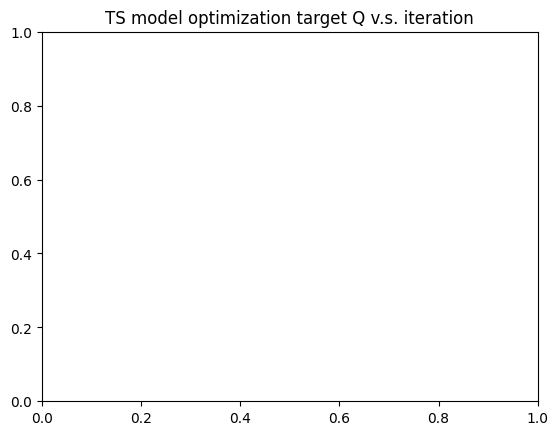

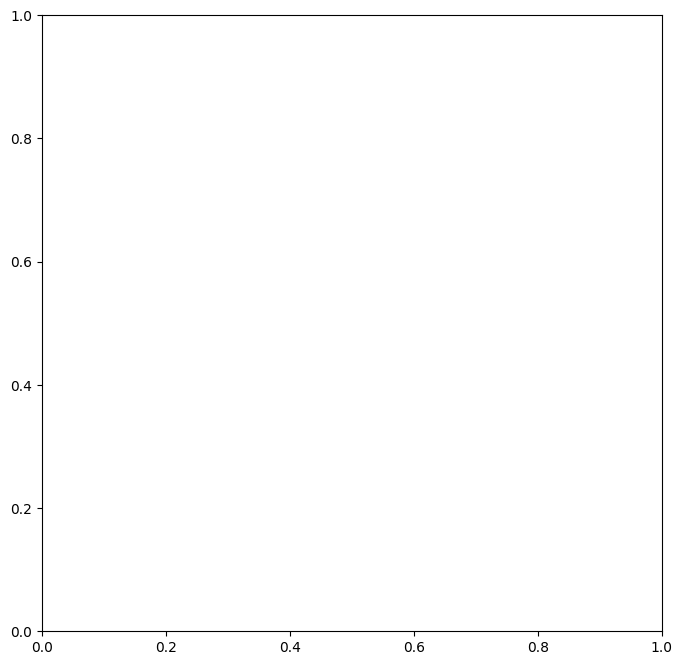

In [92]:
# Plot Q vs # of Nc
# Fcm hyperparameters
FCM_Ncs = [2,3,5,8,10,15,20,25,30,40,50,80]
FCM_m = 2
tol = 1e-5
max_iter = 200
qs = []

for FCM_Nc in FCM_Ncs:   
    N = opt_x.shape[0]
    U = np.random.rand(N, FCM_Nc)
    U = U / np.sum(U, axis=1, keepdims=True)
    temp_qs = []

    # Fuzzy C-Means 聚类
    for _ in range(max_iter):
        U_old = U.copy()
        mf = U ** FCM_m
        cen = np.dot(mf.T, opt_x) / np.sum(mf, axis=0, keepdims=True).T
        dists = cdist(opt_x, cen)
        tmp = np.power(dists, -2 / (FCM_m - 1))
        U = tmp / np.sum(tmp, axis=1, keepdims=True)

        q = np.sum((U ** FCM_m) * (dists ** 2))
        temp_qs.append(q)

        # 检查是否收敛
        if np.linalg.norm(U - U_old) < tol:
            break
    # 模型训练 find if this can be optimized
    z = np.hstack((np.ones((N, 1)), opt_x))
    H = np.zeros((N, FCM_Nc * (opt_x.shape[1] + 1)))

    # 生成模糊规则矩阵 H
    for j in range(FCM_Nc):
        Uj = np.tile(U[:, j], (opt_x.shape[1] + 1, 1)).T
        H[:, (j * (opt_x.shape[1] + 1)):((j + 1) * (opt_x.shape[1] + 1))] = Uj * z

    # 计算权重 W
    W = pinv(np.dot(H.T, H)).dot(H.T).dot(opt_y)

        
    # 在训练集上进行预测
    y_hat_train = np.dot(H, W)
    mse_train = mean_squared_error(opt_y, y_hat_train)
    rmse_train = sqrt(mean_squared_error(opt_y, y_hat_train))
    print("FCM traning RMSE:", rmse_train)
    qs.append(temp_qs)
    
plt.title('TS model optimization target Q v.s. iteration')
plt.figure(figsize=(8,8))
plt.plot(qs)

In [ ]:
plt.figure(figsize=(8,8))

for exp in qs:
    plt.plot(exp)

plt.legend(FCM_Ncs, title="Number of rules")
plt.title('TS model optimization target Q v.s. iteration for differenct number of rules')